# Advanced Housing Dataset Exploration
1.  Introduction
2.  Exploring the Data
3.  Plotting the Data
4.  Training the Model

# Introduction


Hello. My name is Evan Freeman. I'm currently just messing around with pandas, matplotlib, and seaborn, and scikit-learn to improve my data analysis and visualization skills. I know this analysis is rather simplistic and makes some arbitrary selections. But I'm primarily focusing on my competence with these libraries, not so much on the optimal data science procedures.

## Procedure

1. Split Validation Data (Test data is already seperate, Kaggle will test my model on that data)
  1. 80 / 20 Split
  2. k-fold cross validation
    1. I'll have to rerun the whole pipeline for each fold
    2. I've read that 5 or 10 folds are good. Not sure why exactly those numbers.
2. Visually investigate the data
3.  Feature Generations 
  1. Categorical Parings
  2. Numerical Transformations 
4.  Feature Selection
  1. Univariate
  2. Lasso (L1)
  3. Ridge (L2)
5.  Try different models
  1.  Simple Regression
  2.  Random Forest
  3.  XGBoost
  4.  LightGBM
  5.  Neural Net (lol wut)
6.  Hyperparameter Tuning (my fav)
7.  Compare them!

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

pd.options.display.max_columns = None
pd.options.display.max_rows = 40

housing = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/test.csv')

Note: The test data has already been split for us by Kaggle, but we MUST split off validation data (or do k-fold) as well!!! Otherwise we will overfit.  

Let's split off 20% for validation.  

Later, we'll try with k-fold validation, which should produce better results.  

It is worth pointing out that, once we've trained and validated our model, chosing the best type of model, the best features, the best hyperparameters, we should go back and train it from scratch on the entire dataset (train + valid). If we don't, we're just hamstringing our model by not using all the available data.

Also, we'll create a pipeline for all these steps. For now, we're just exploring.

In [17]:
# Train Valid Split, 80 / 20

train, valid = train_test_split(housing, test_size = .2)

# Plotting the Data

Before we start processing the data, let's visualize the data and see if we can pick out any interesting information that way.

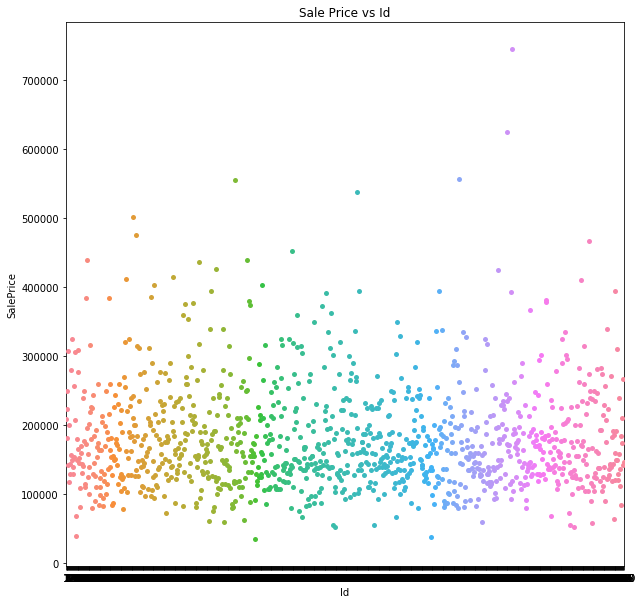

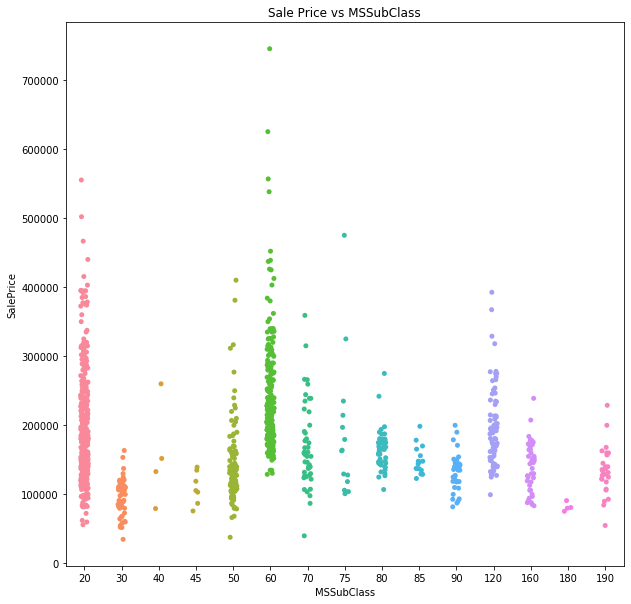

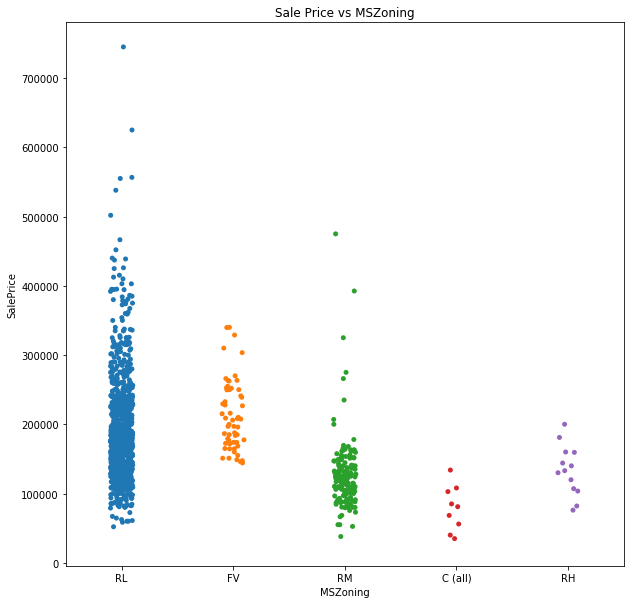

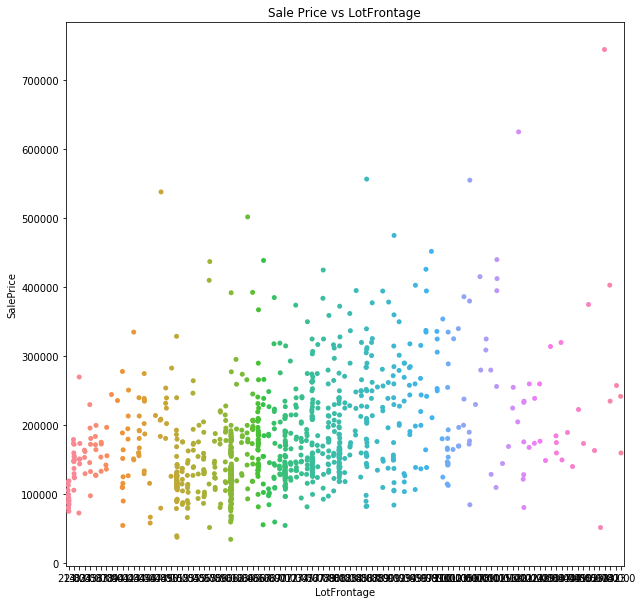

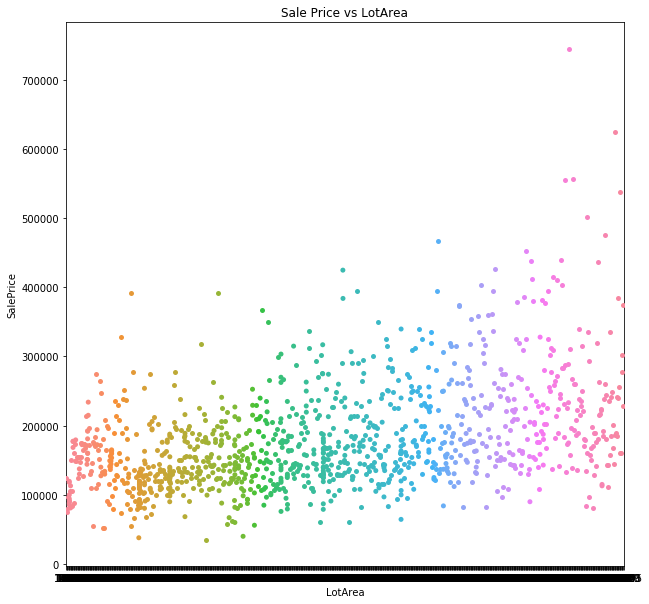

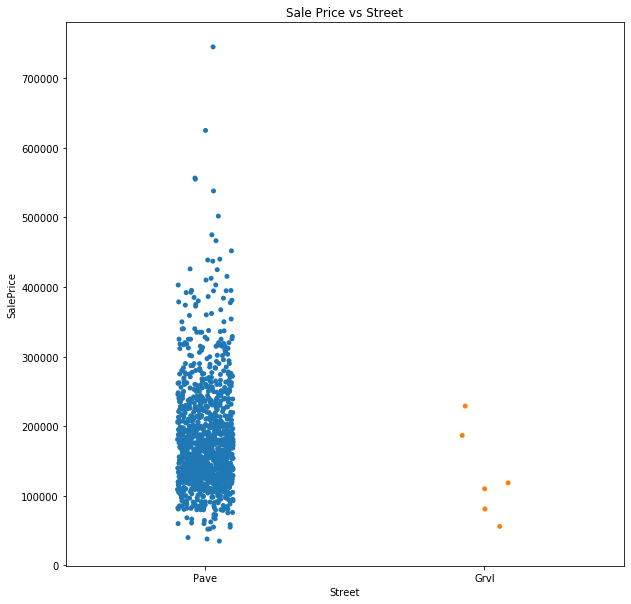

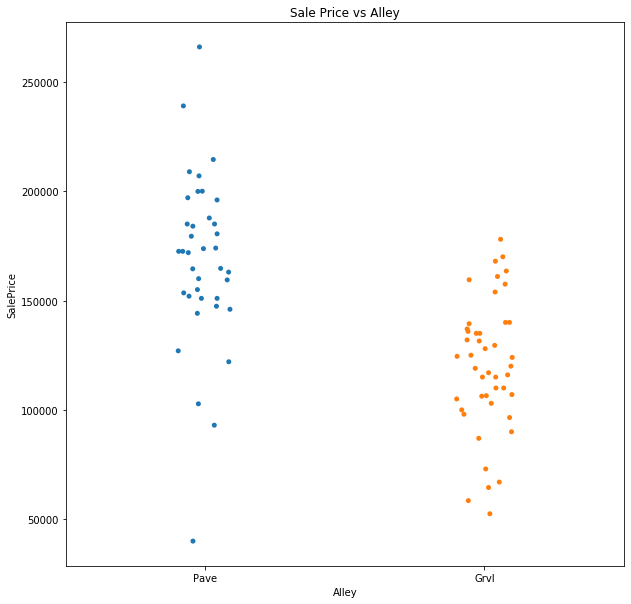

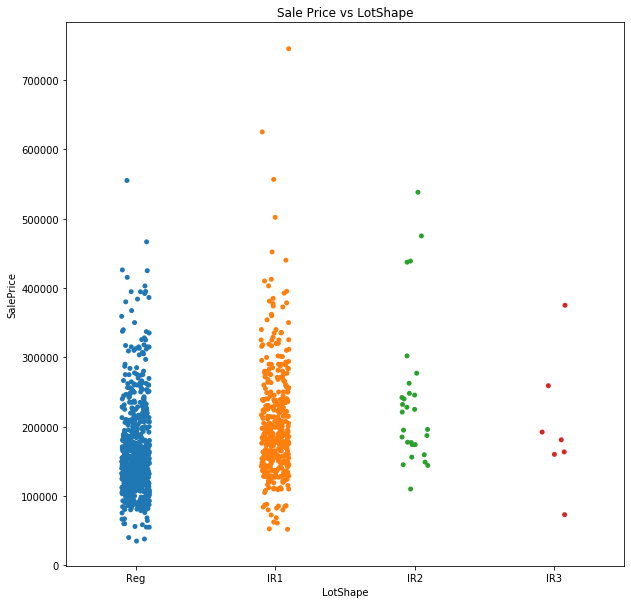

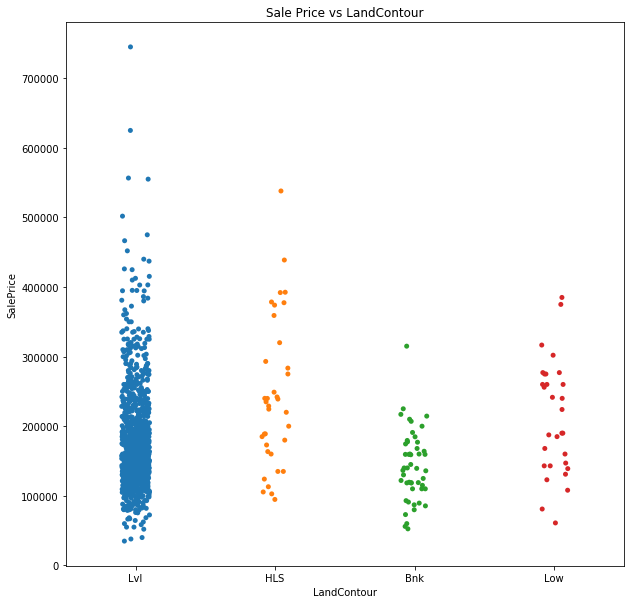

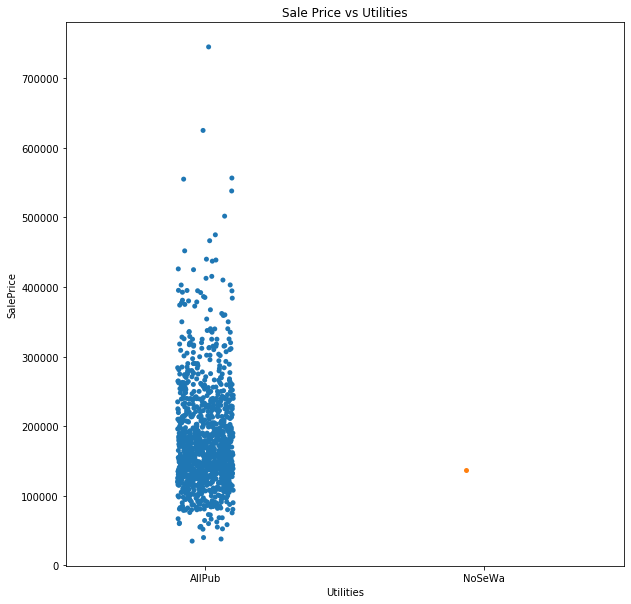

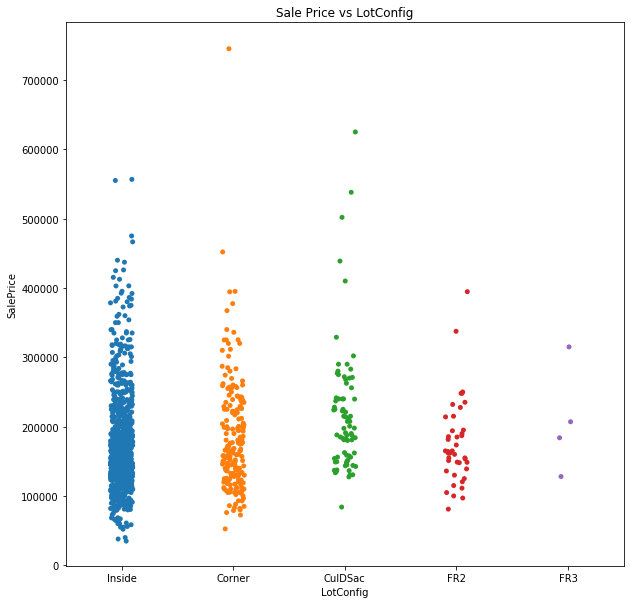

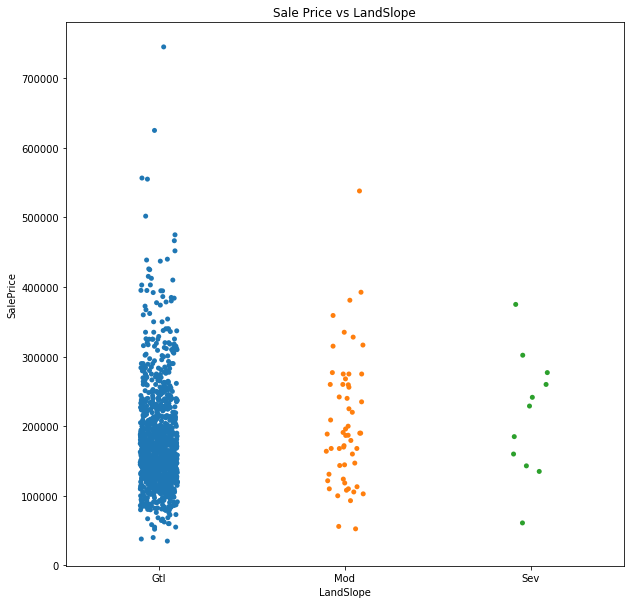

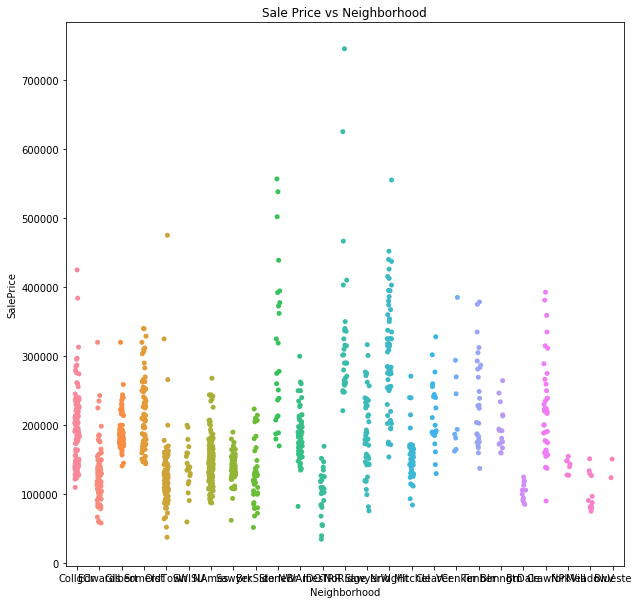

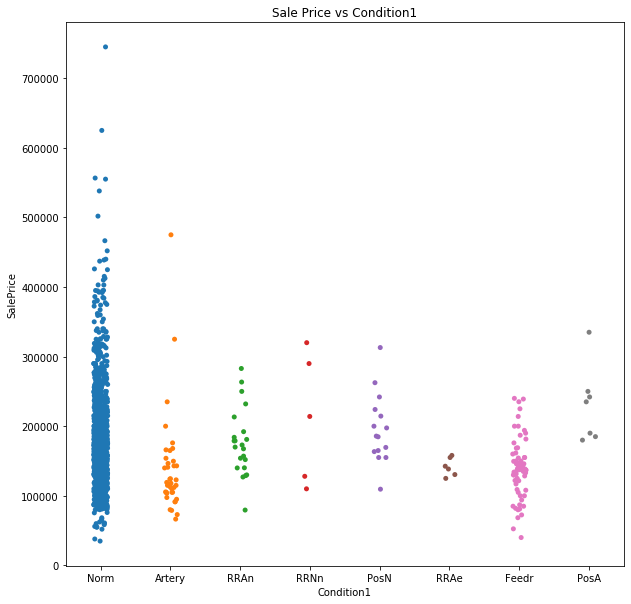

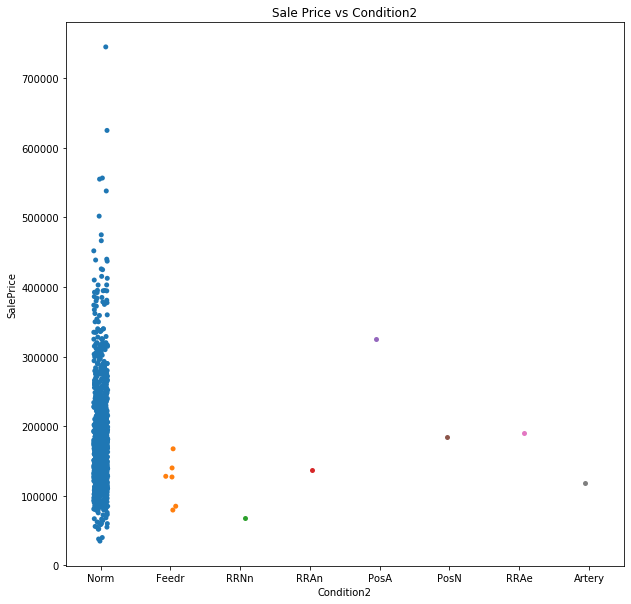

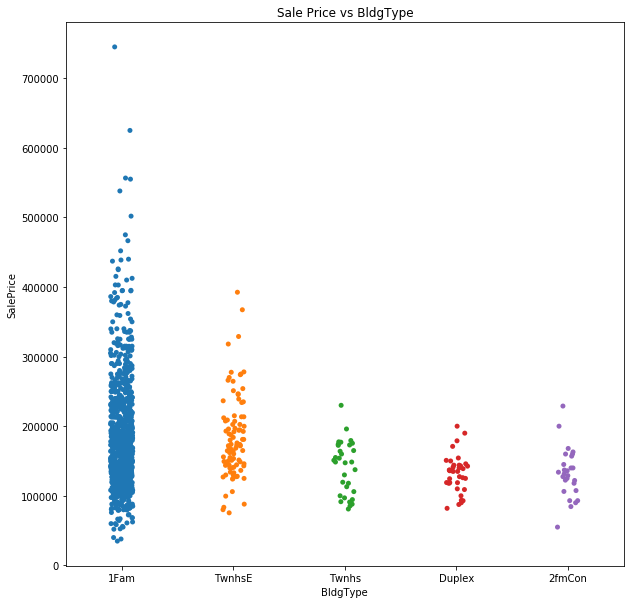

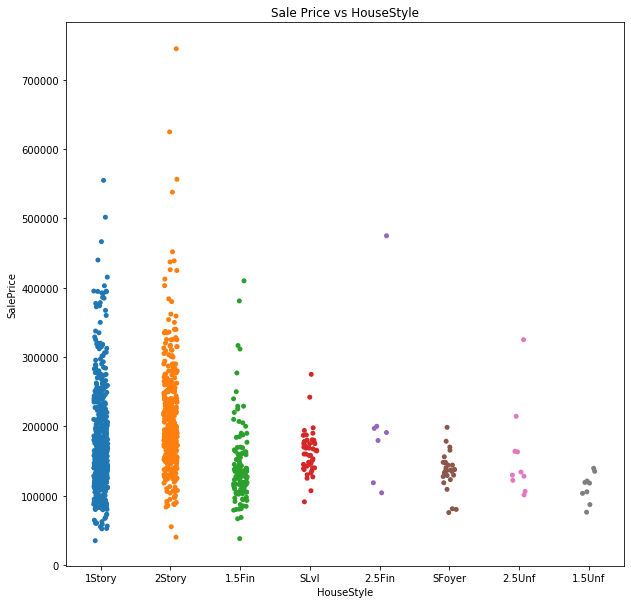

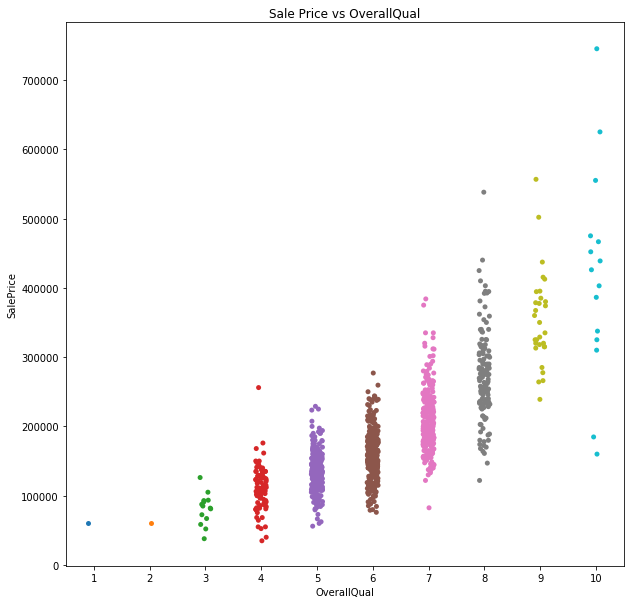

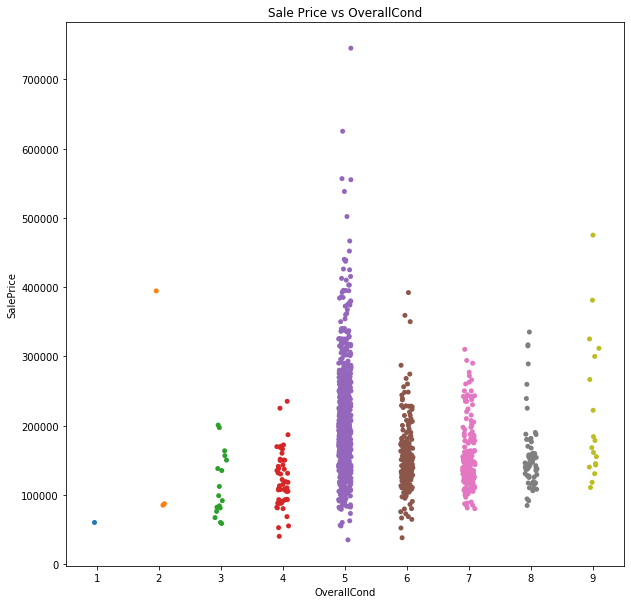

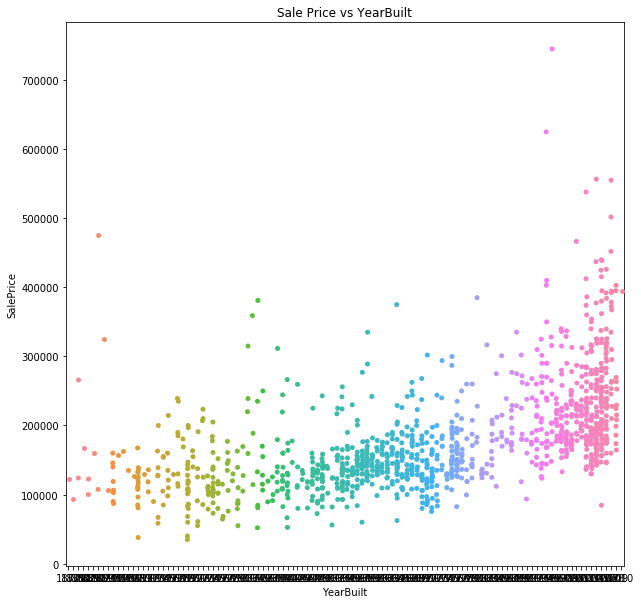

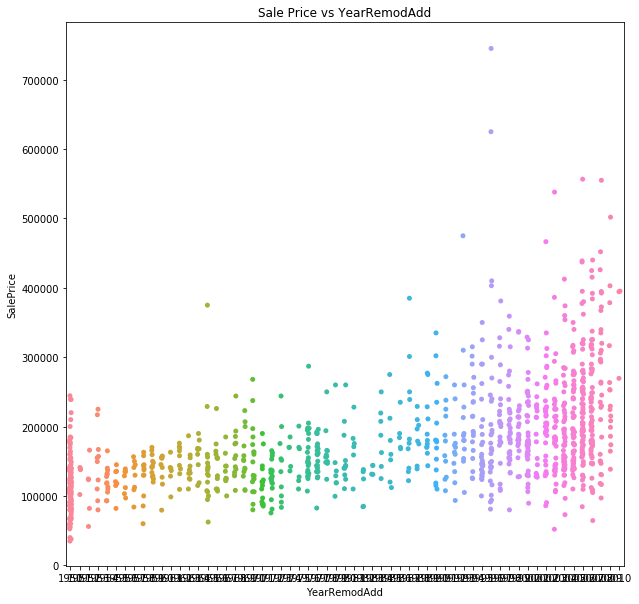

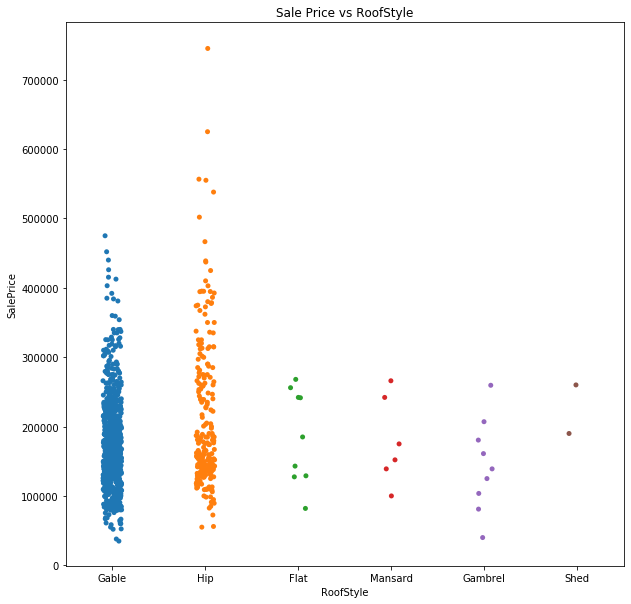

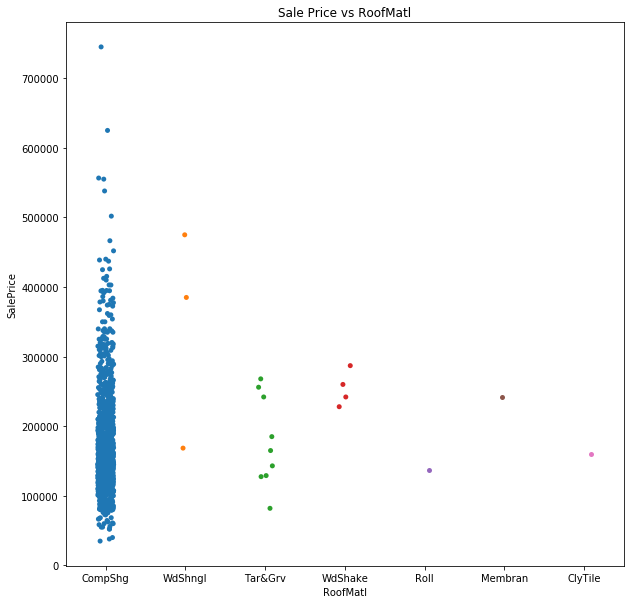

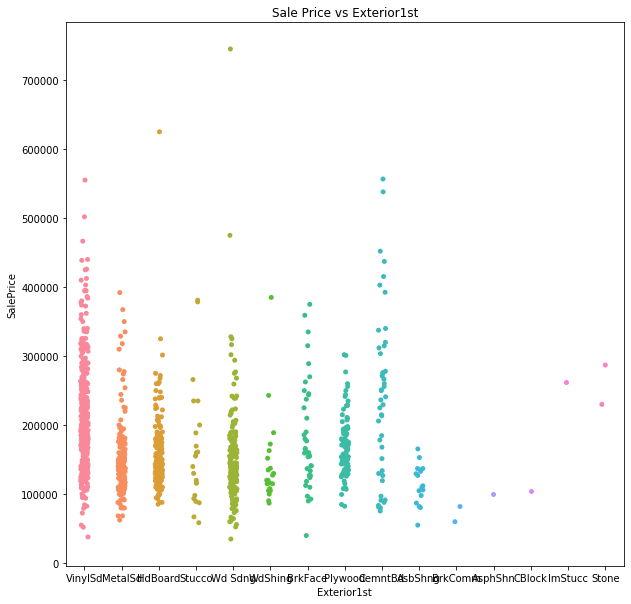

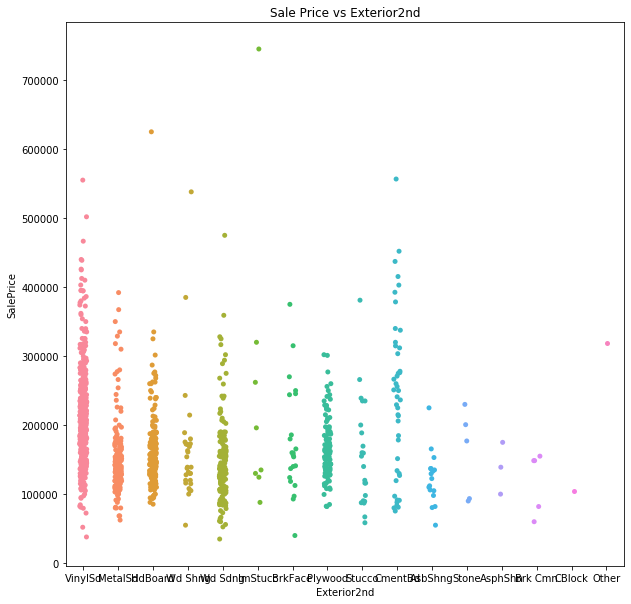

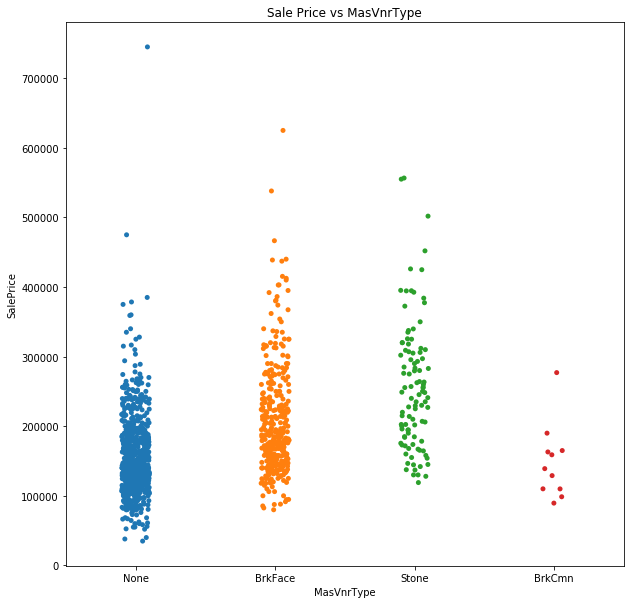

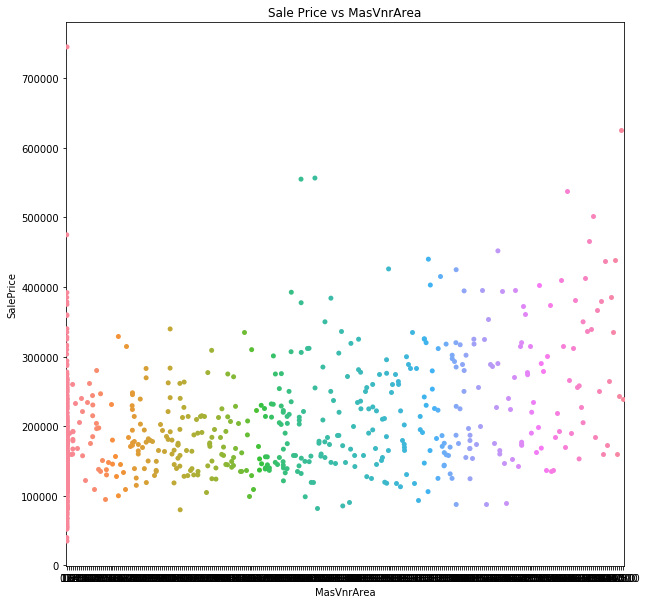

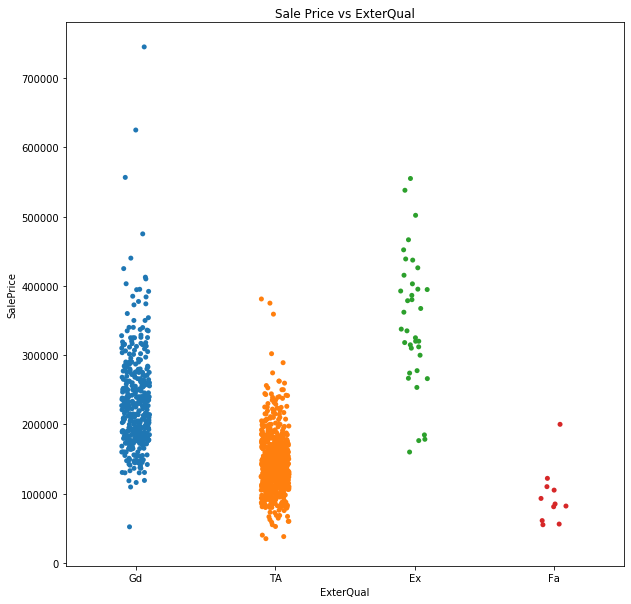

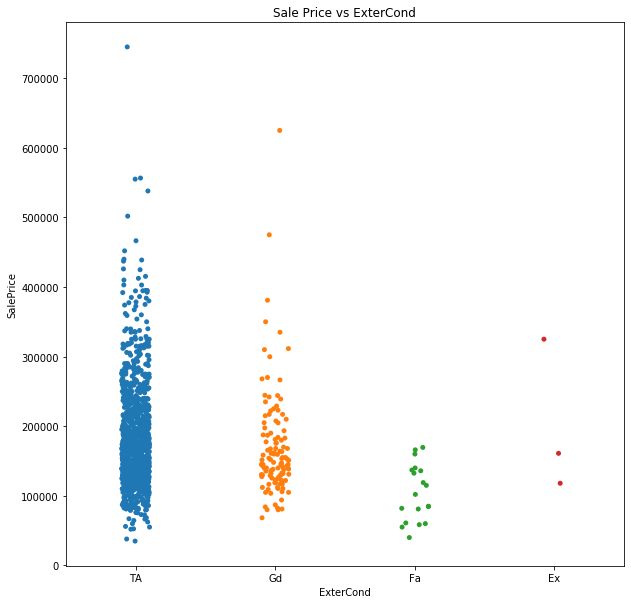

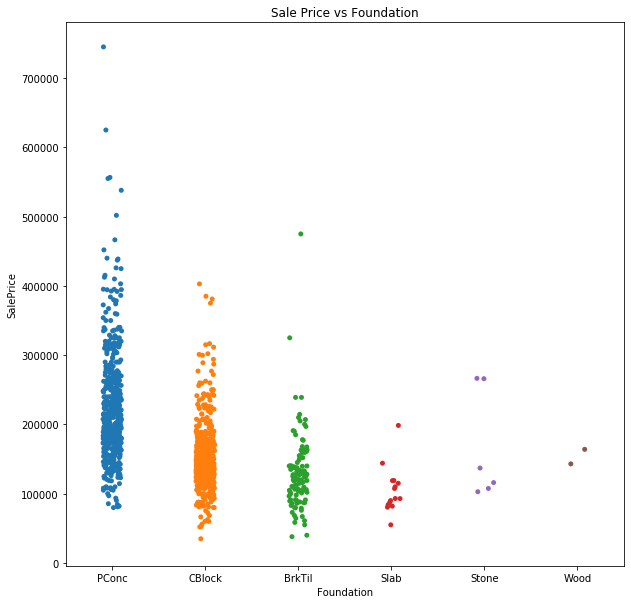

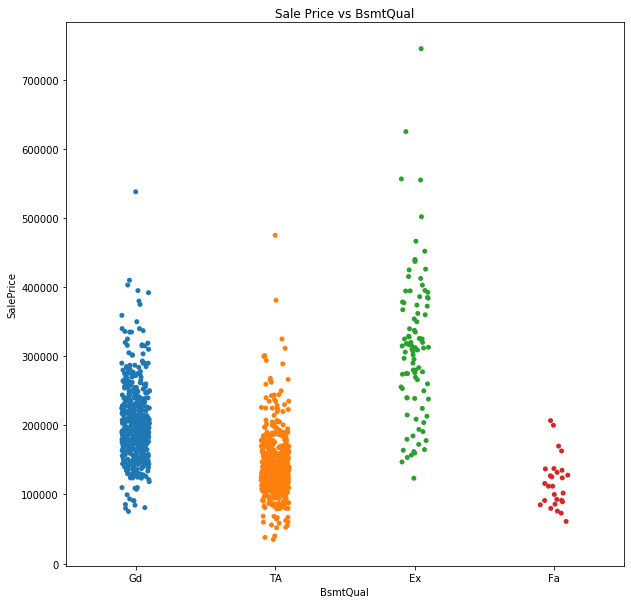

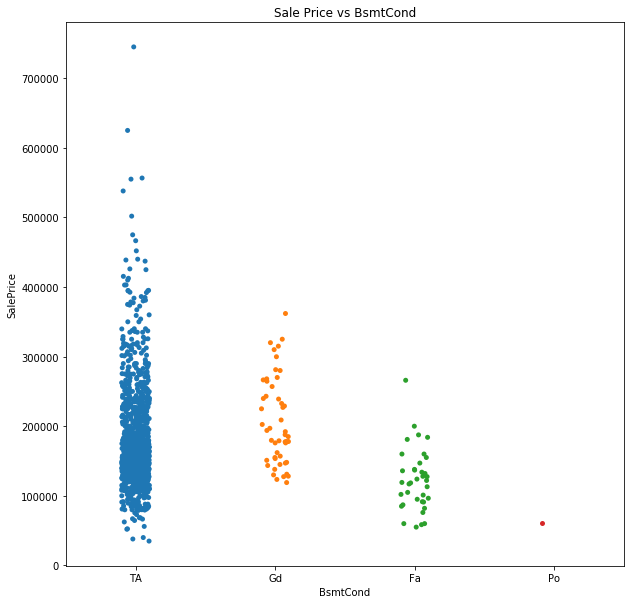

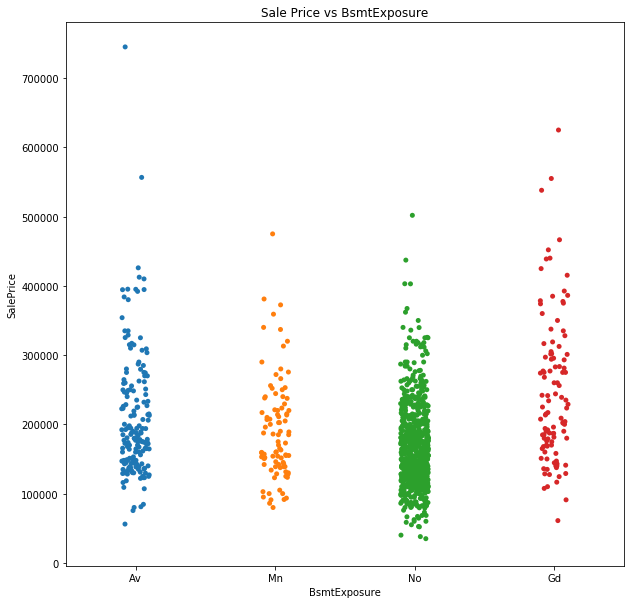

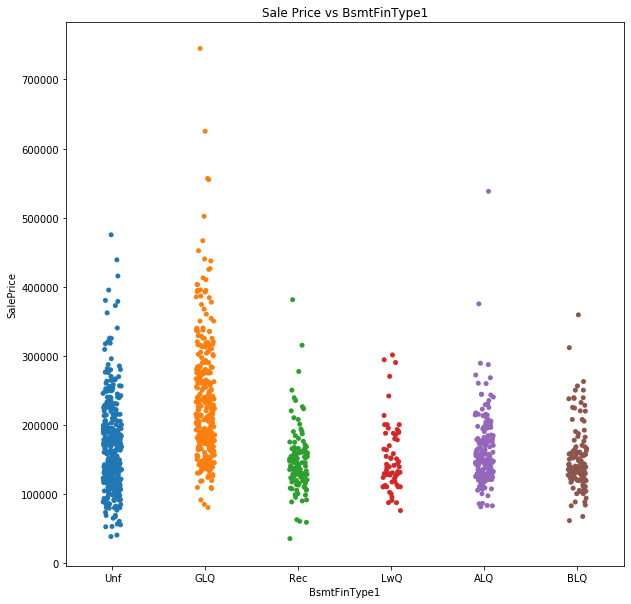

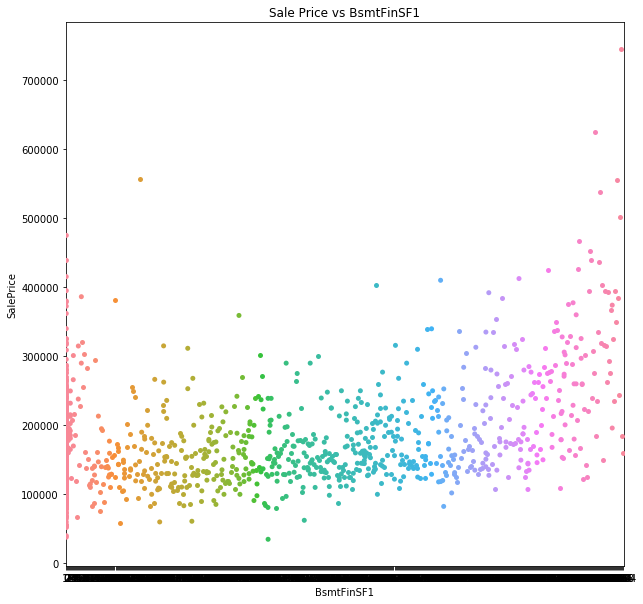

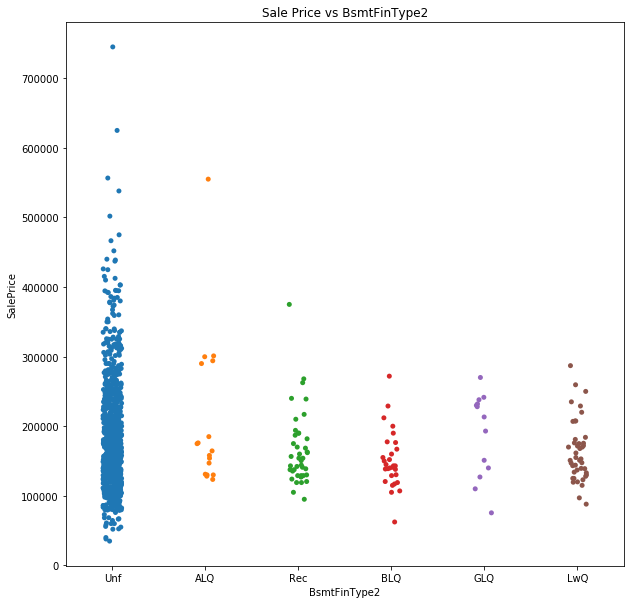

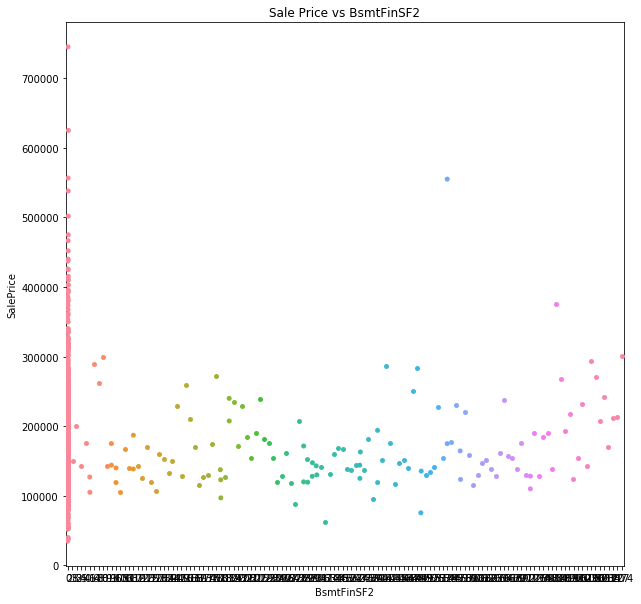

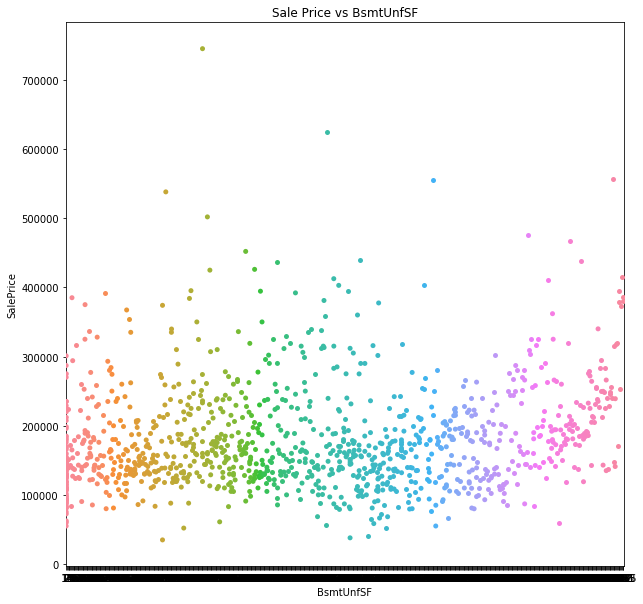

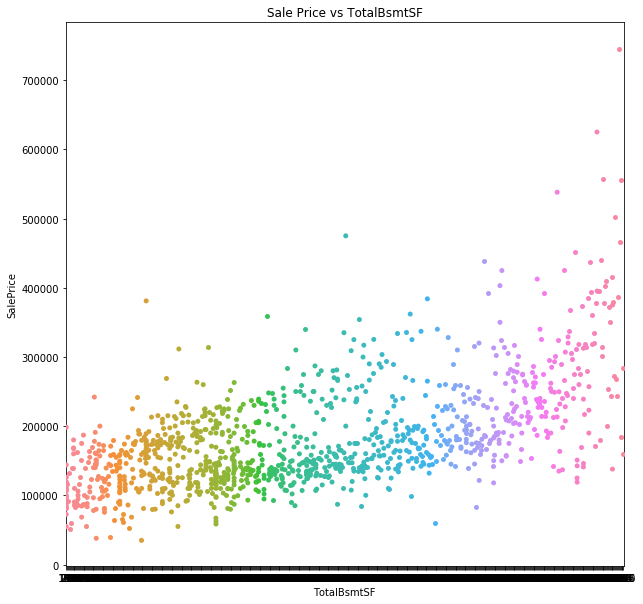

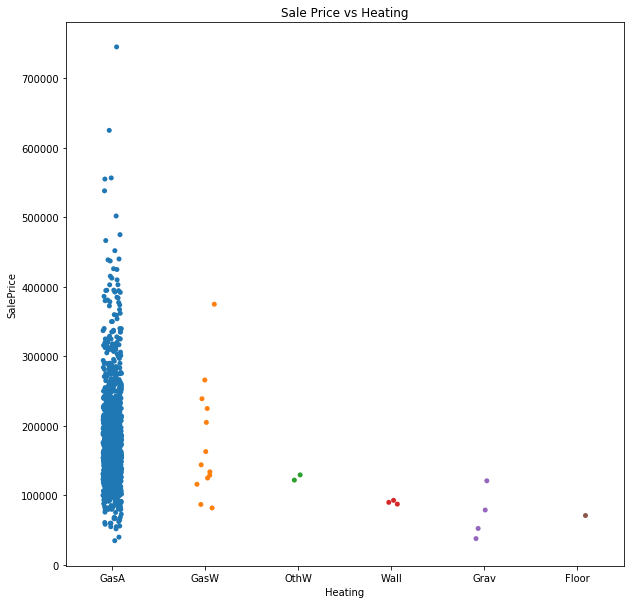

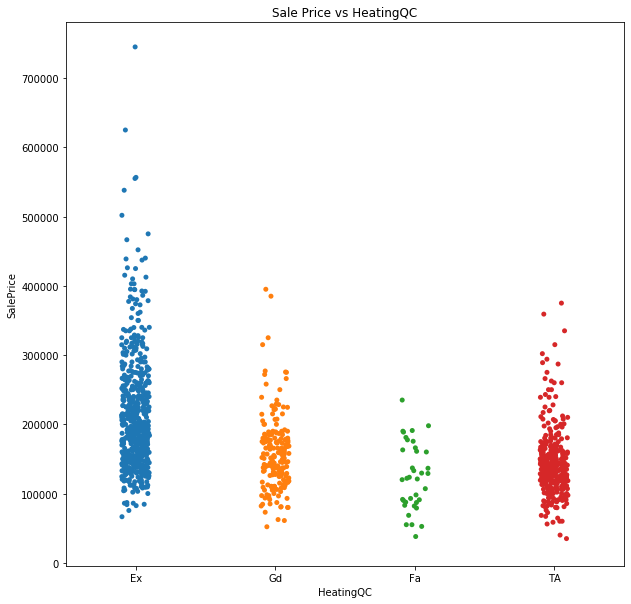

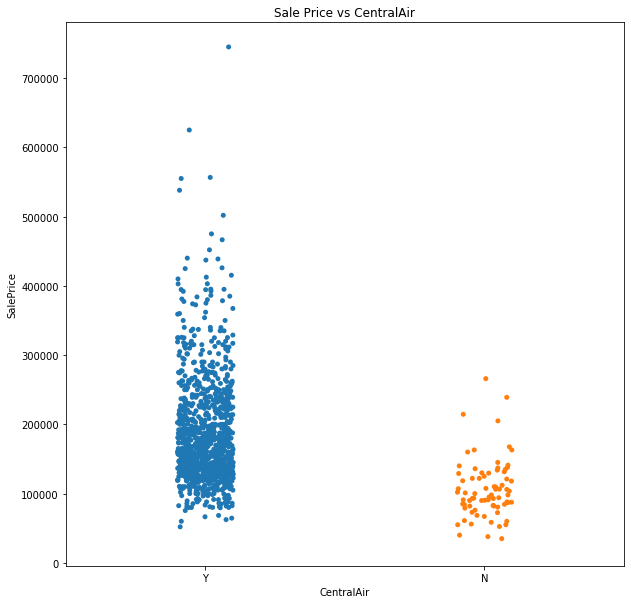

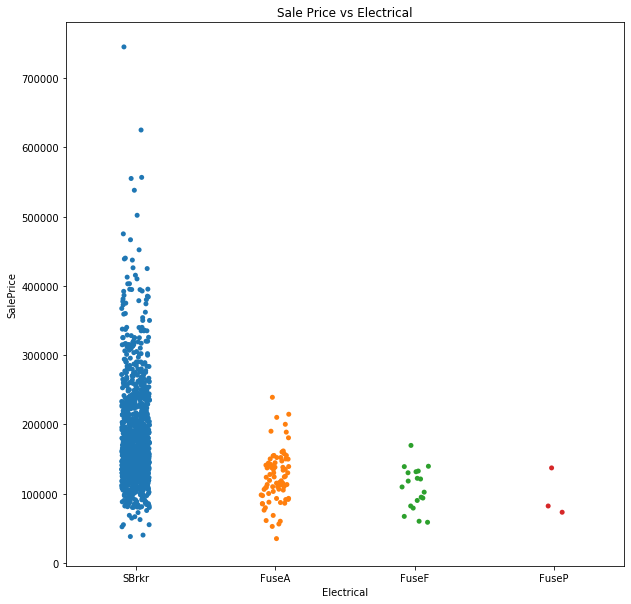

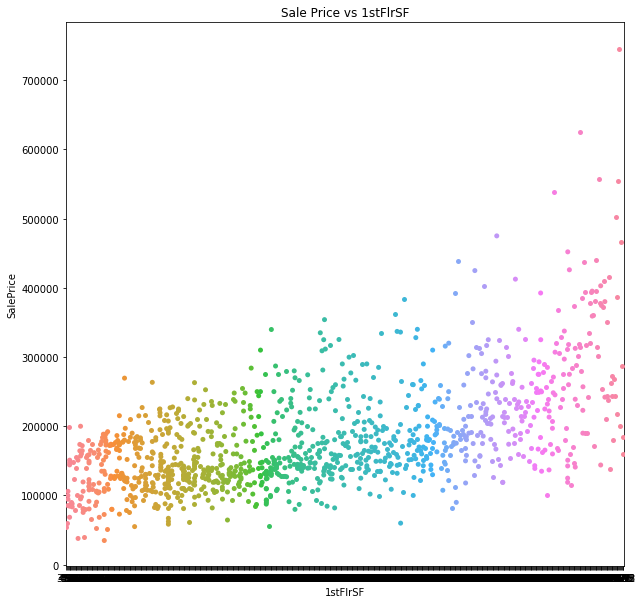

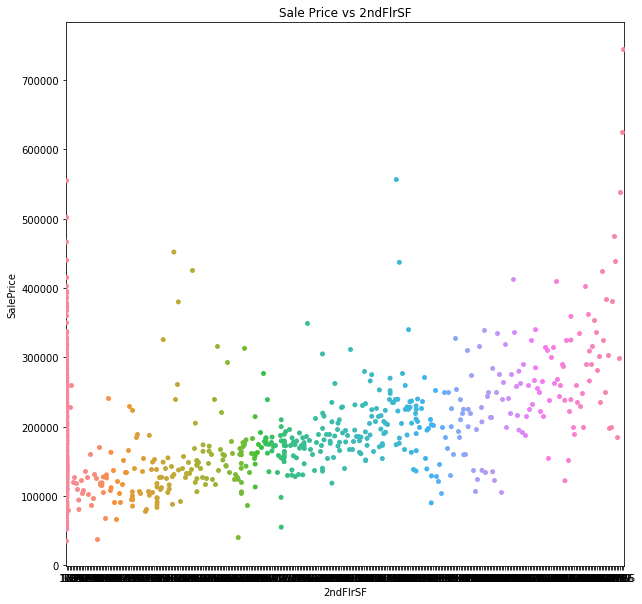

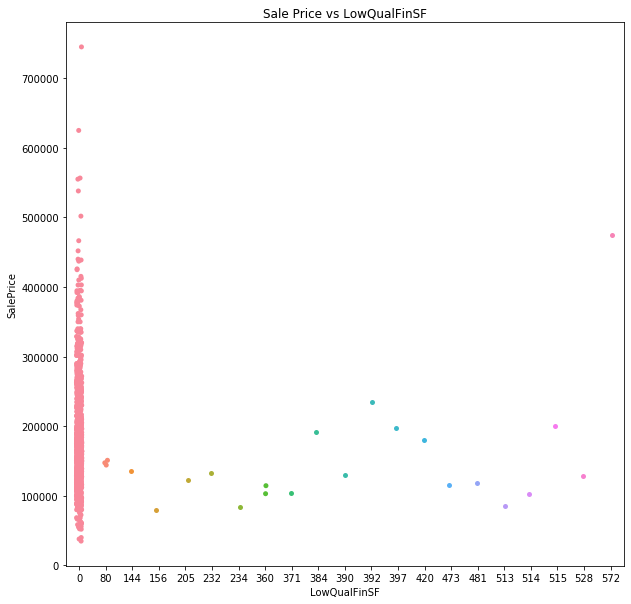

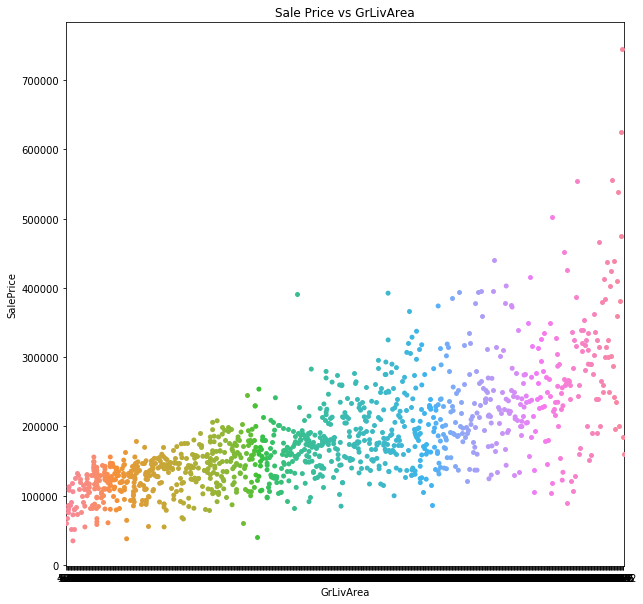

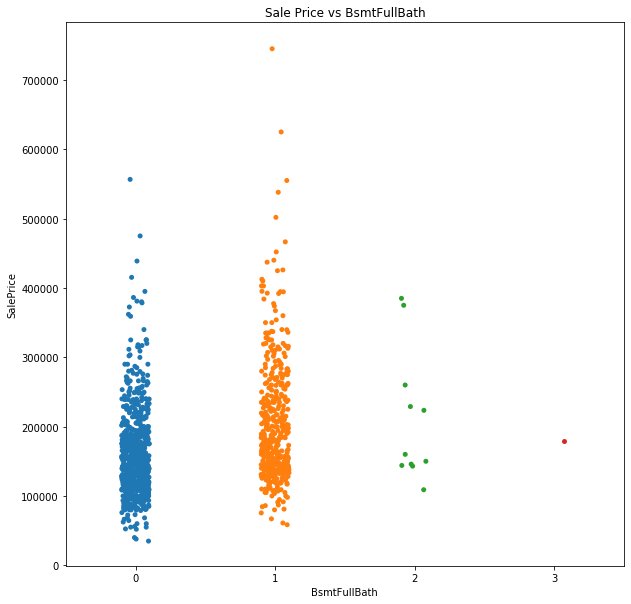

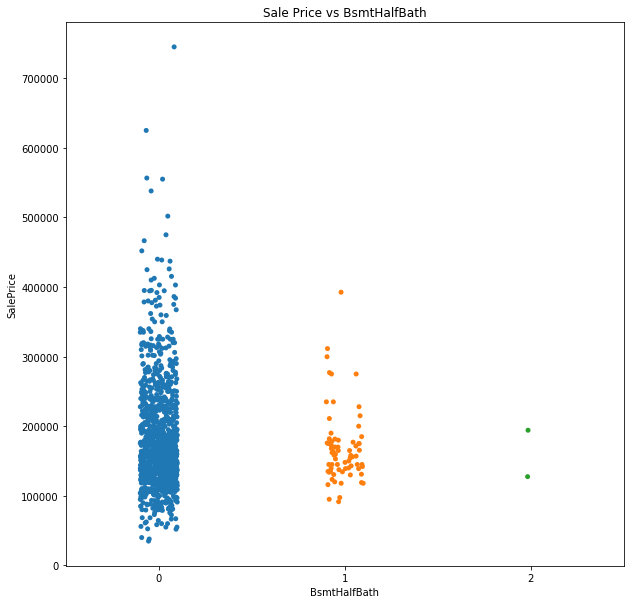

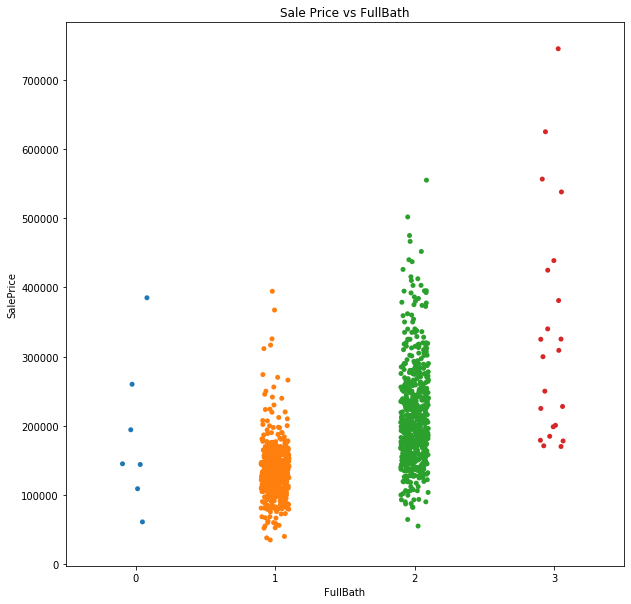

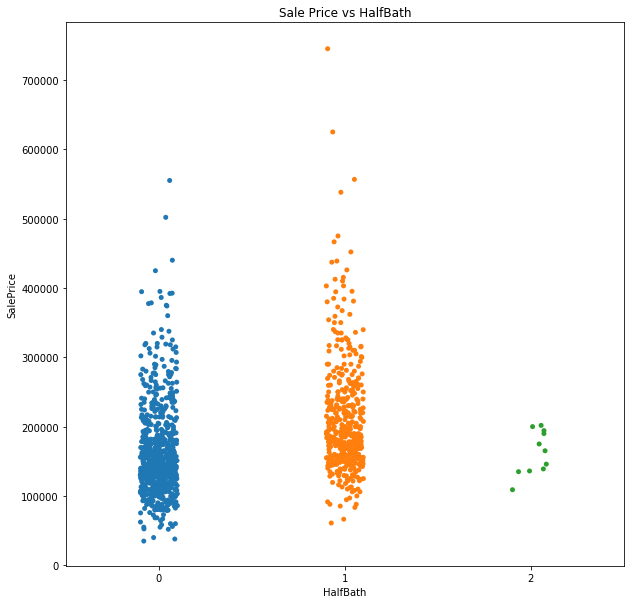

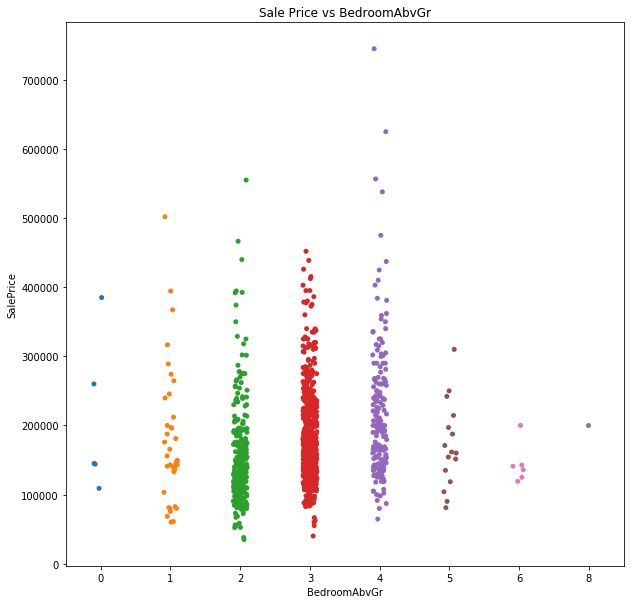

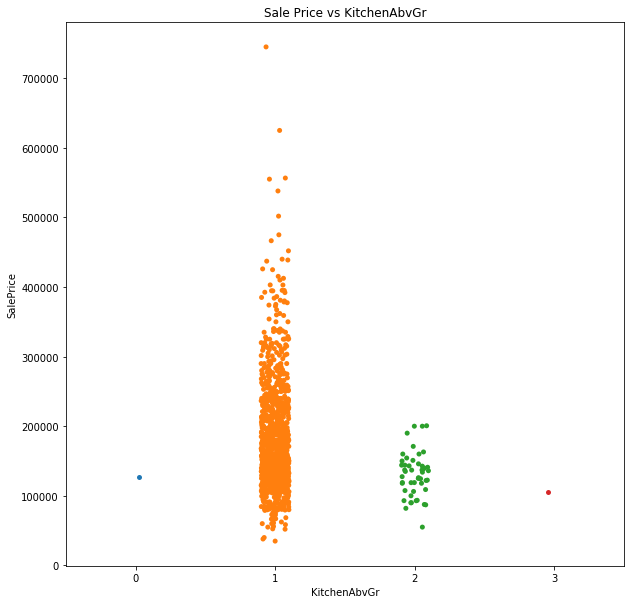

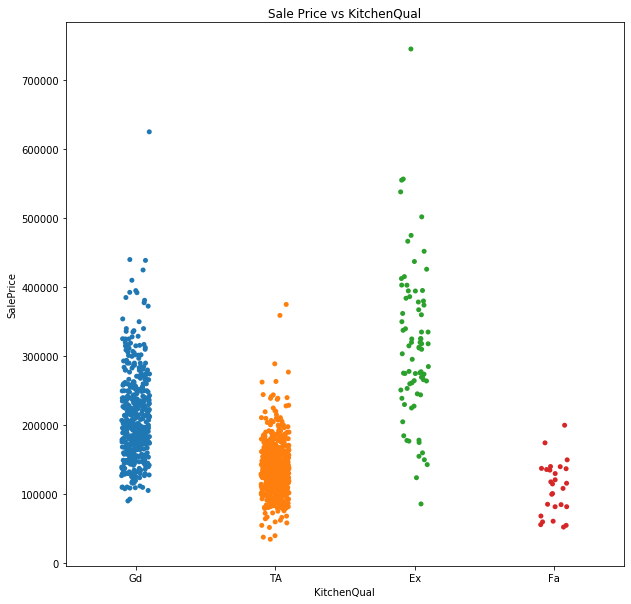

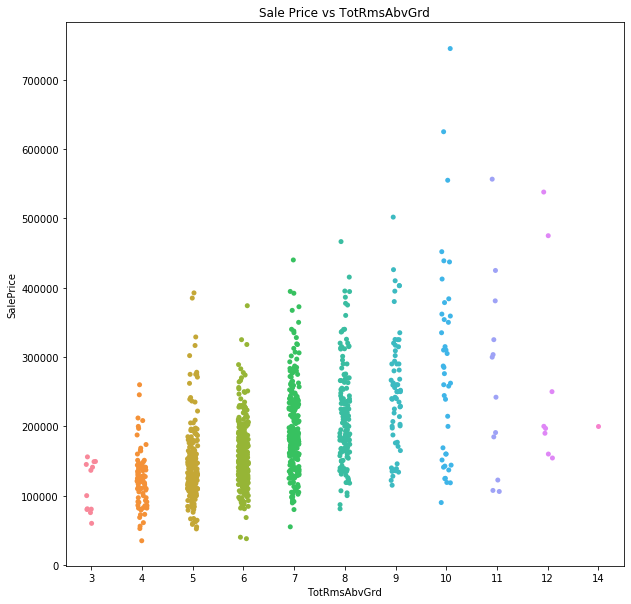

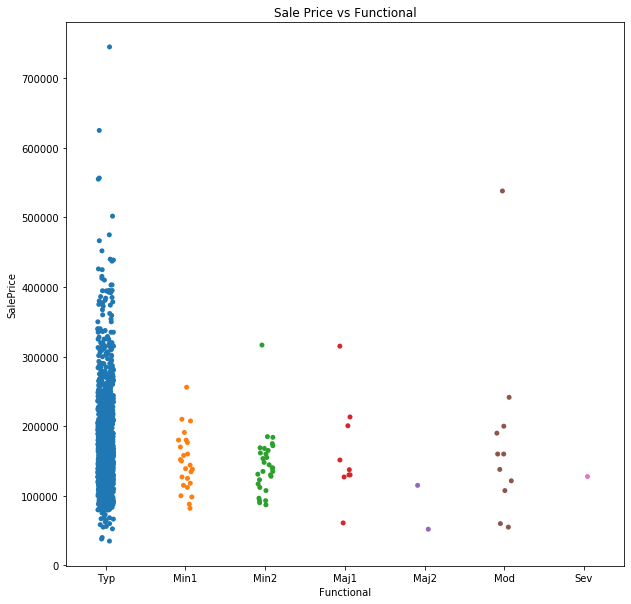

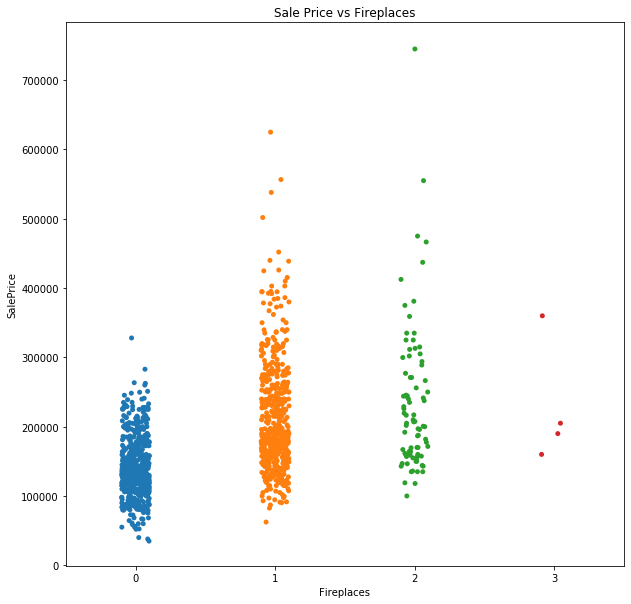

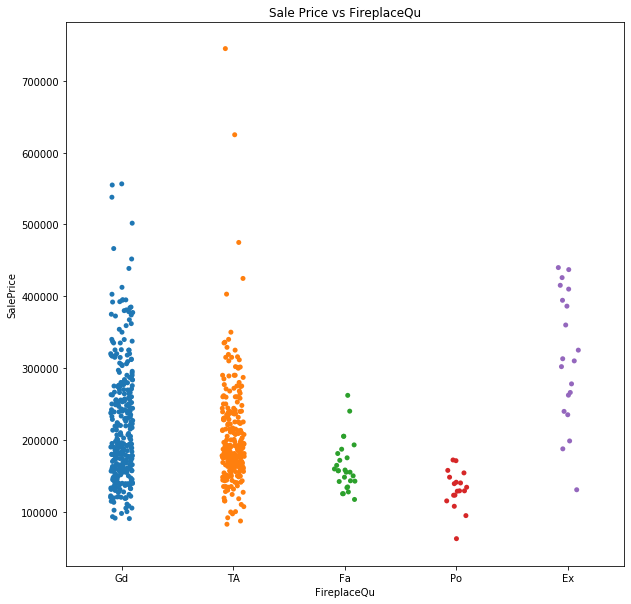

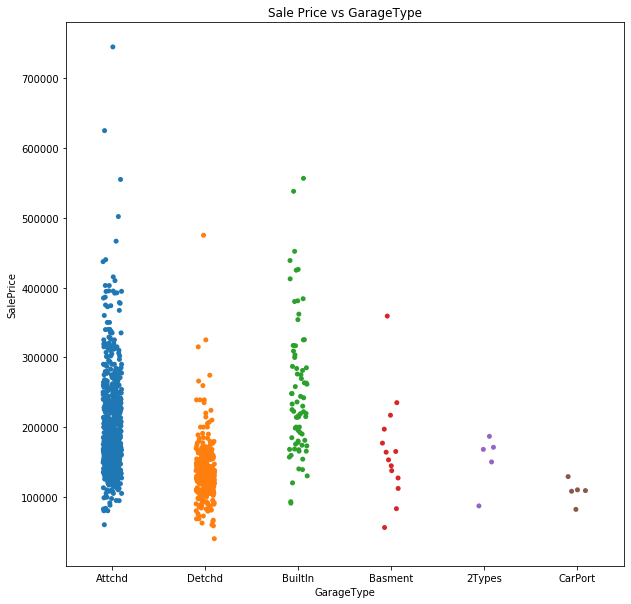

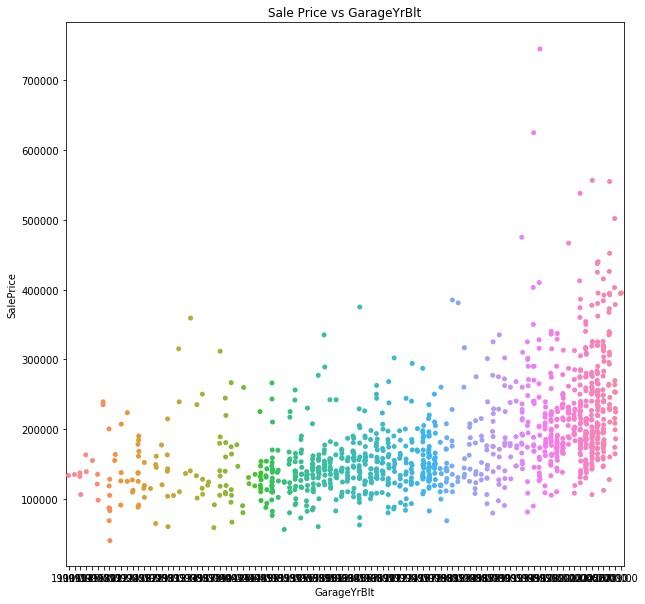

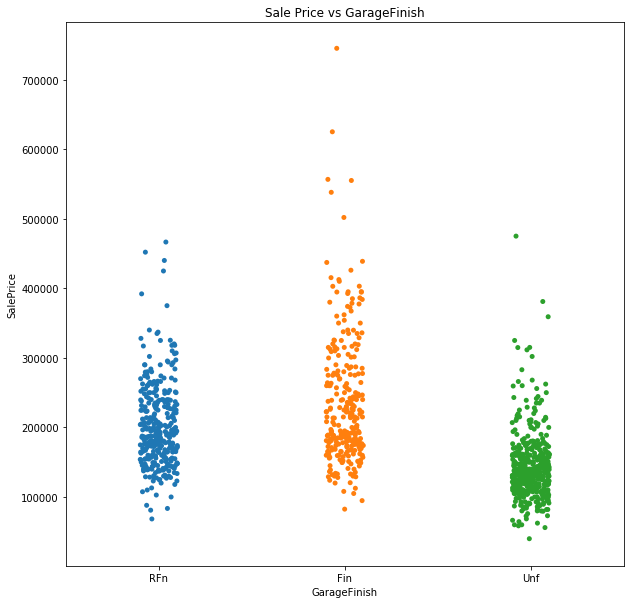

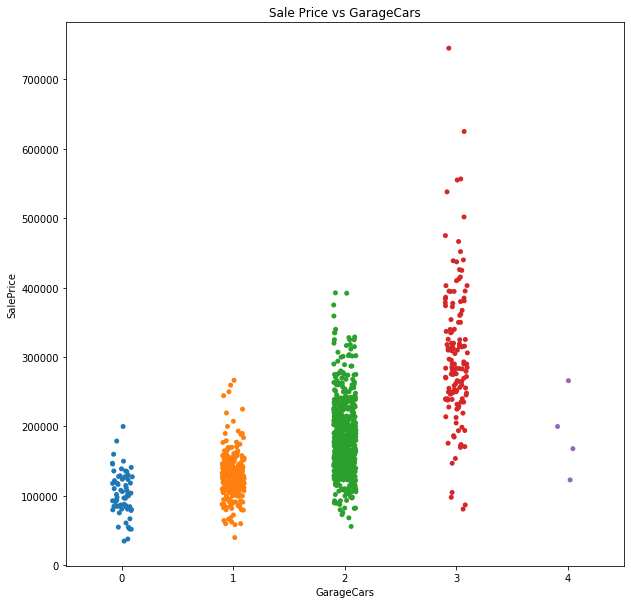

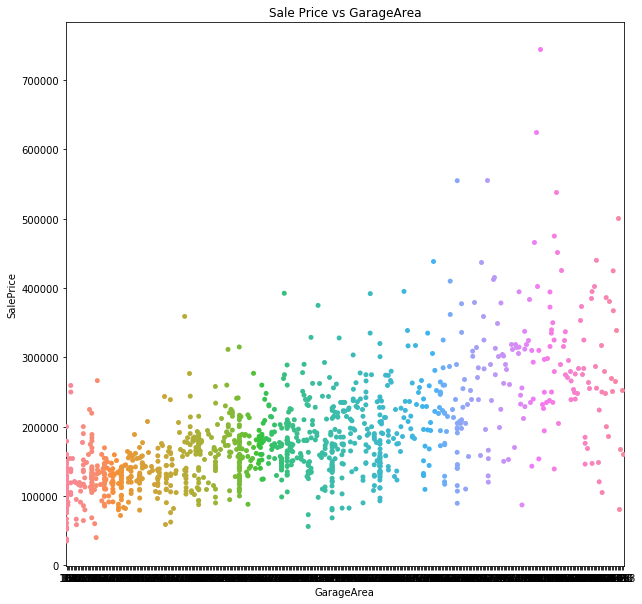

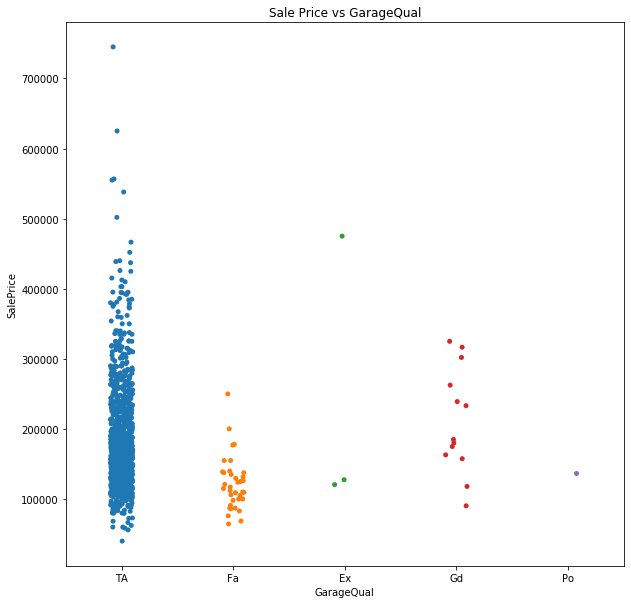

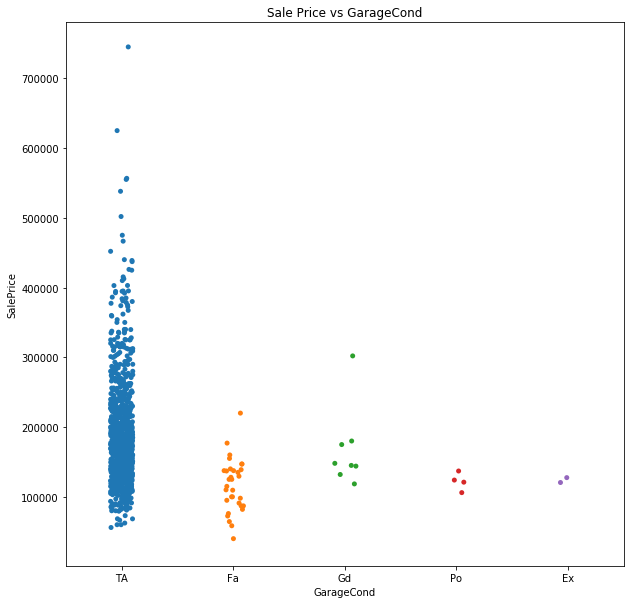

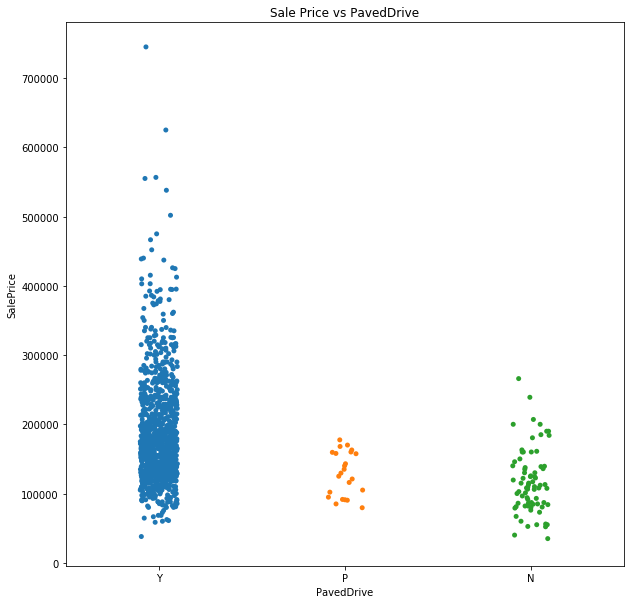

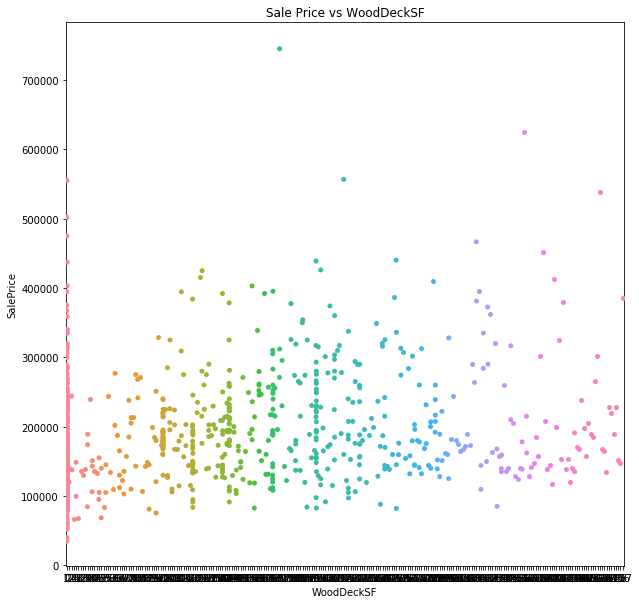

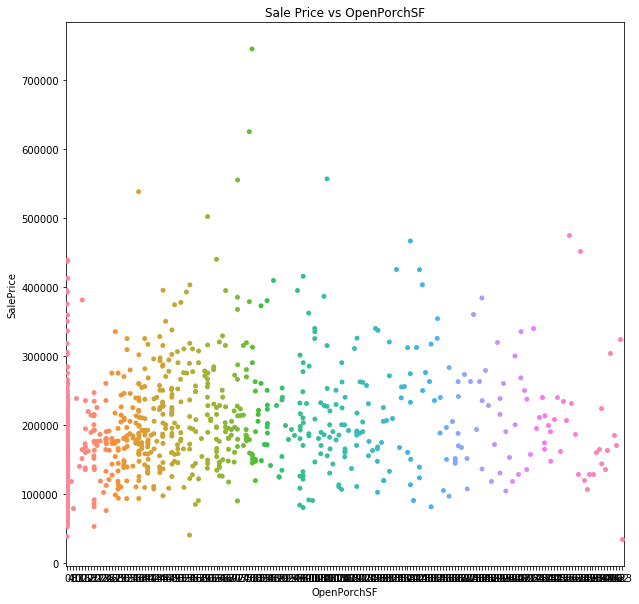

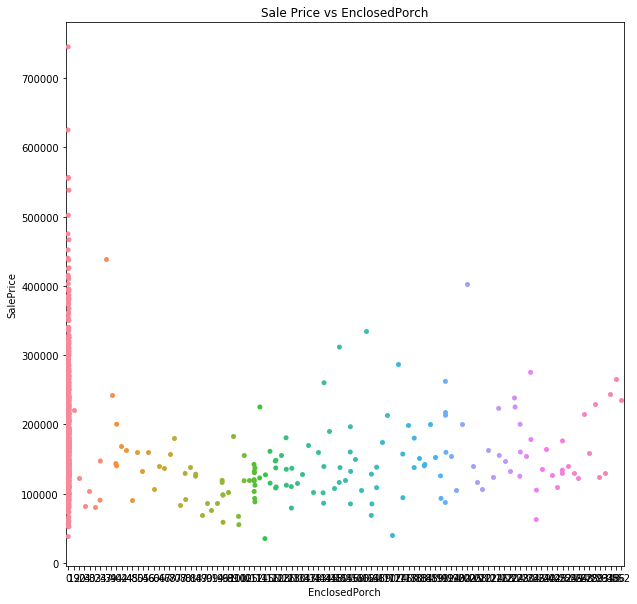

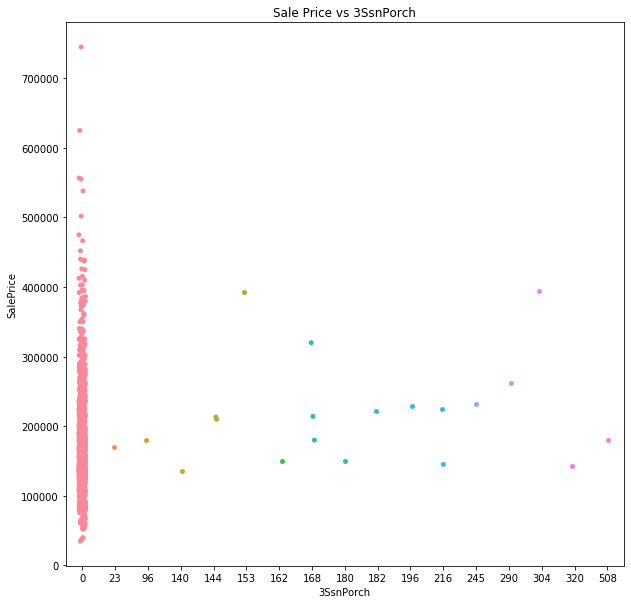

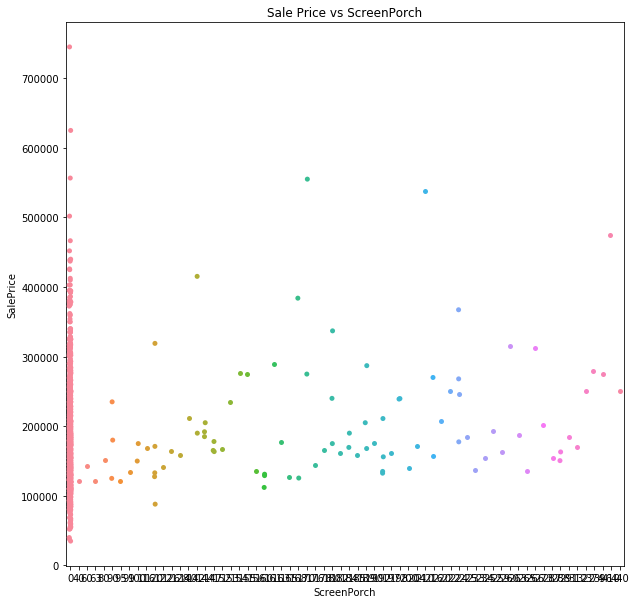

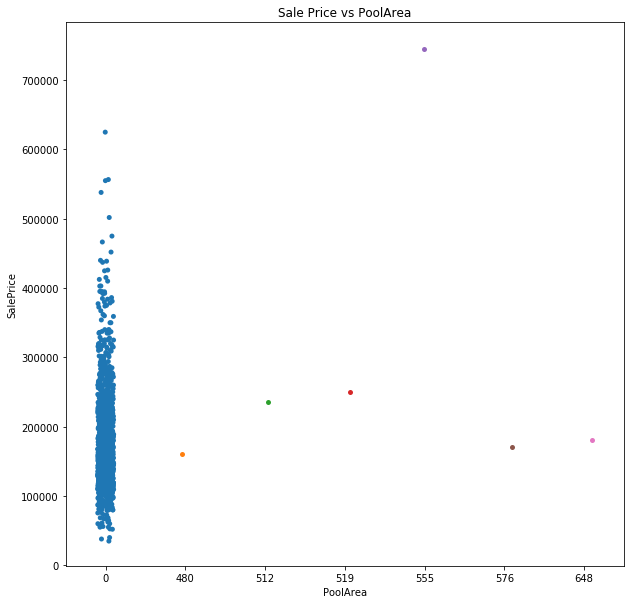

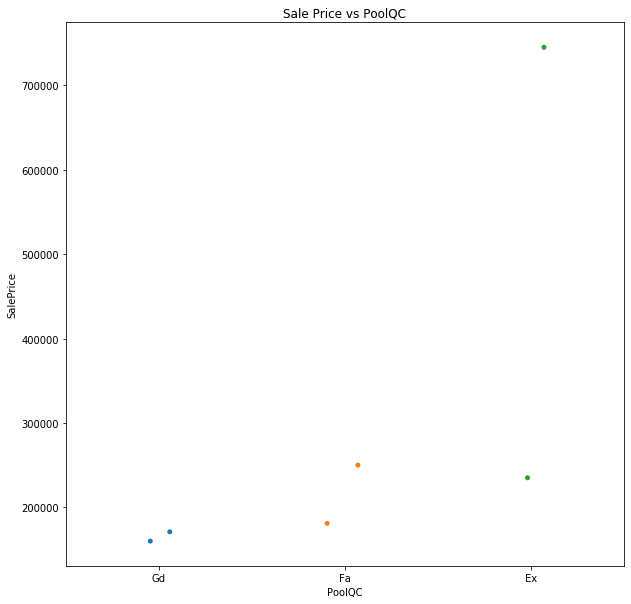

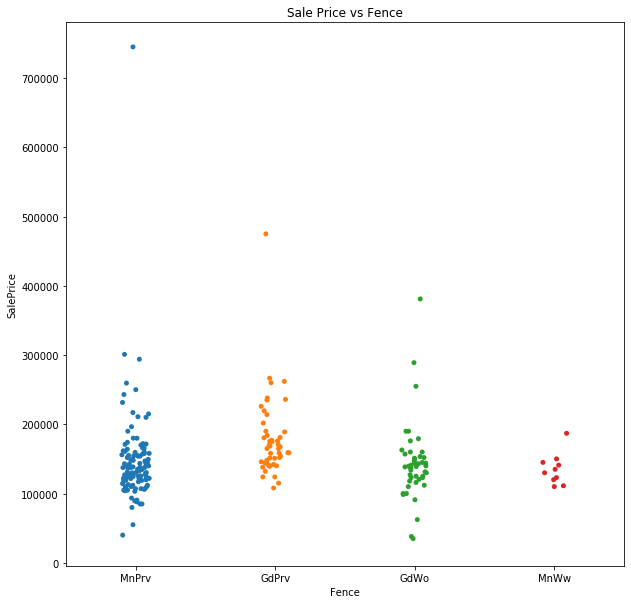

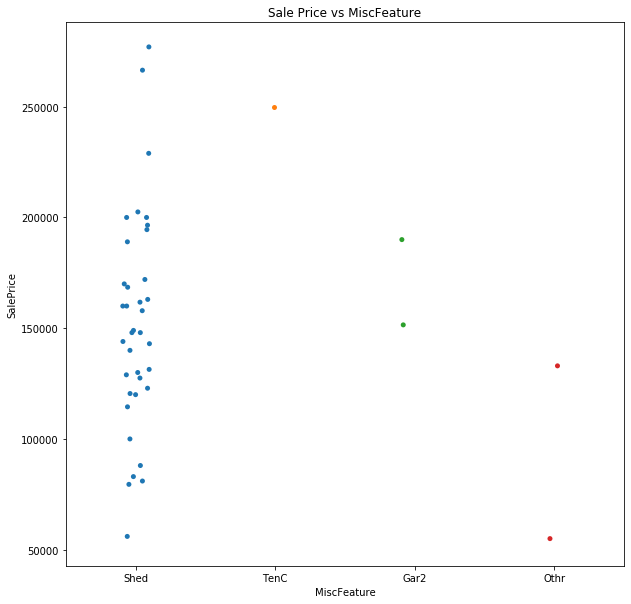

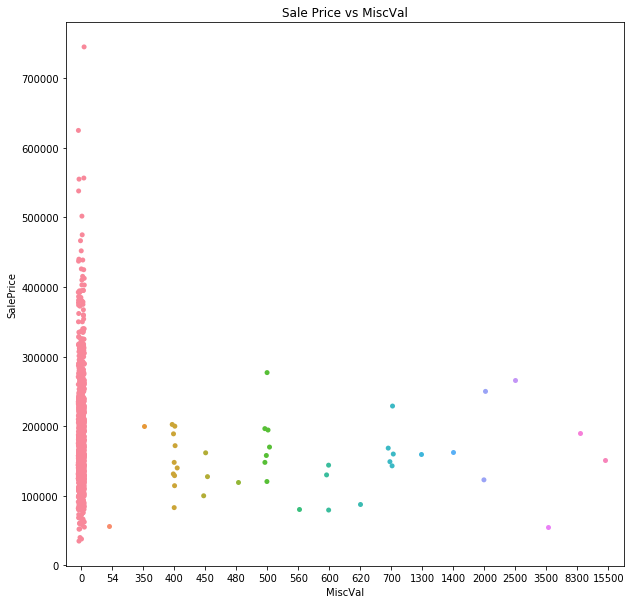

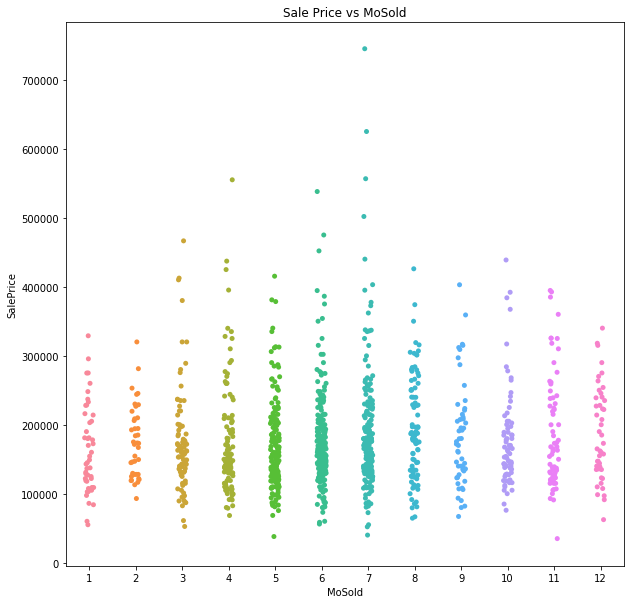

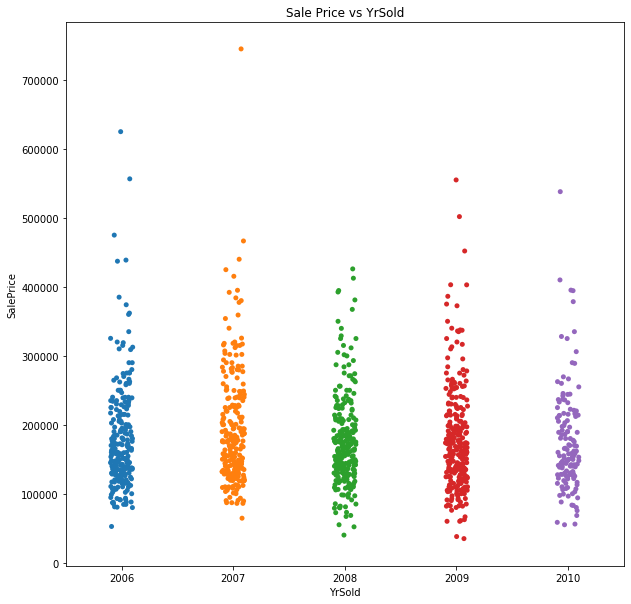

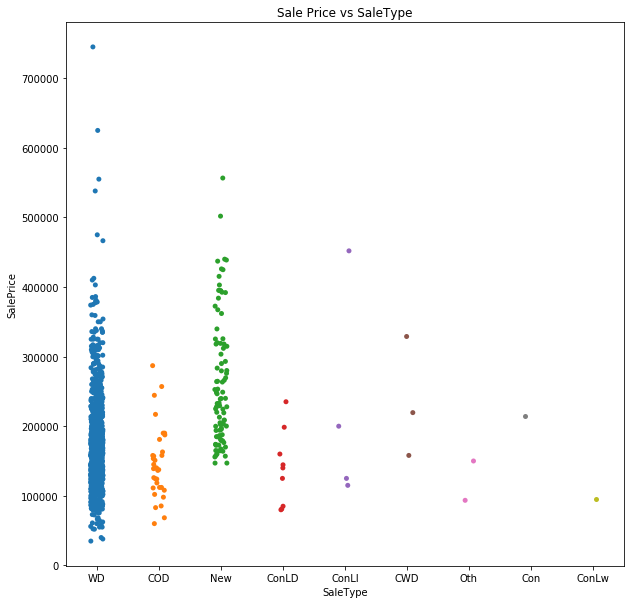

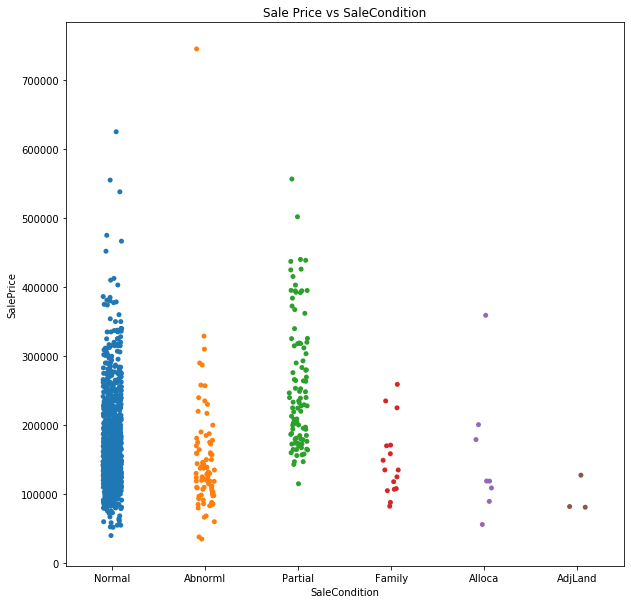

In [3]:
# Scatter Plots for all features vs target

for feature in train.columns:
    if feature != 'SalePrice':
        plt.figure(figsize = (10, 10))
        sns.stripplot(x = feature, y = 'SalePrice', hue = None, data = train)
        plt.title(f'Sale Price vs {feature}')
        plt.show()

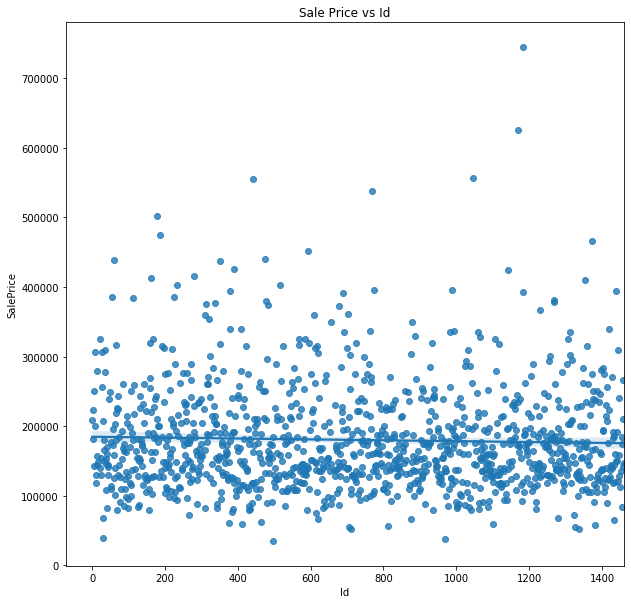

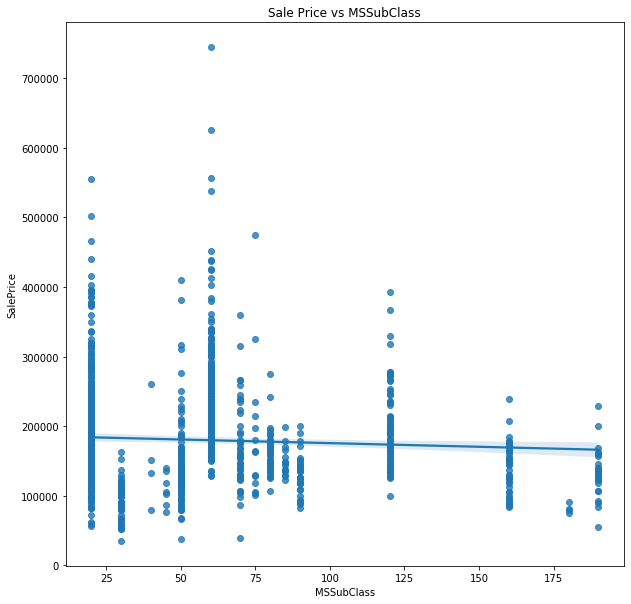

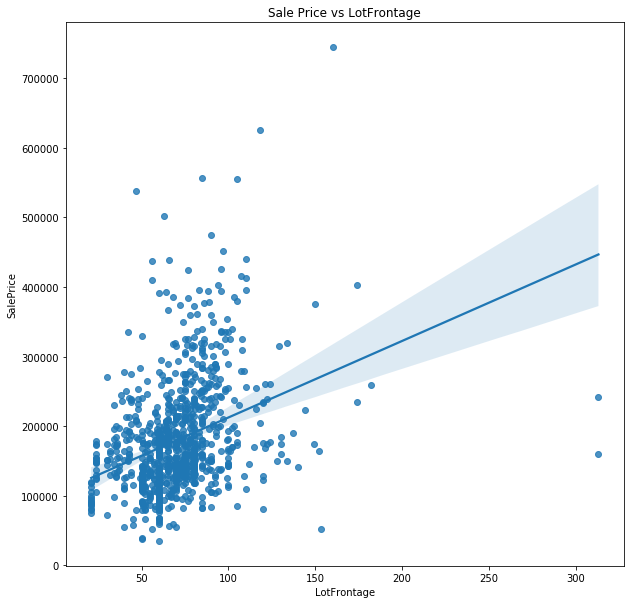

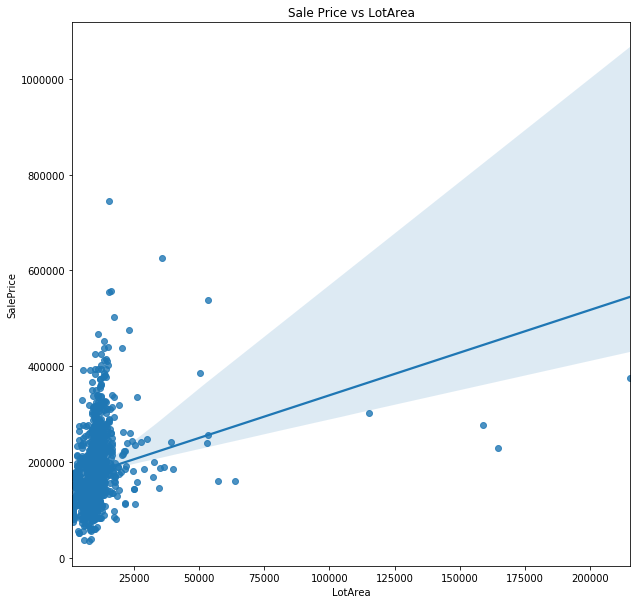

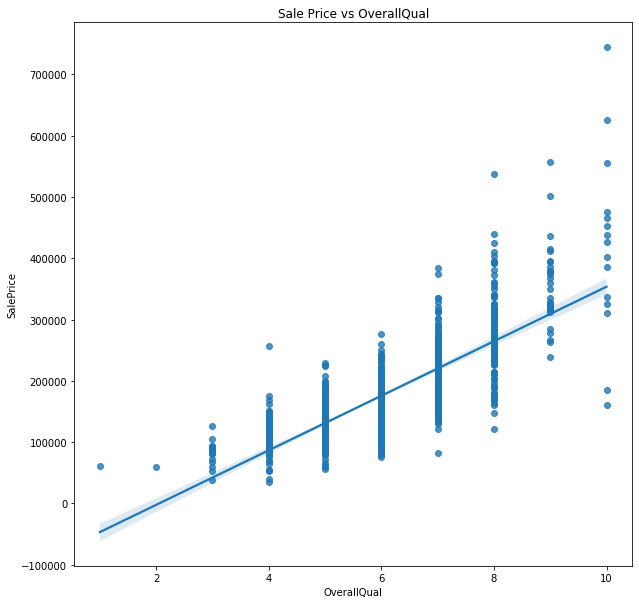

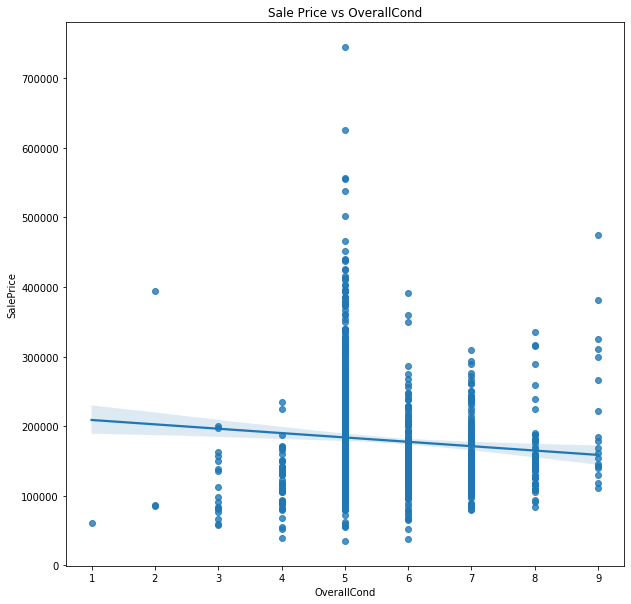

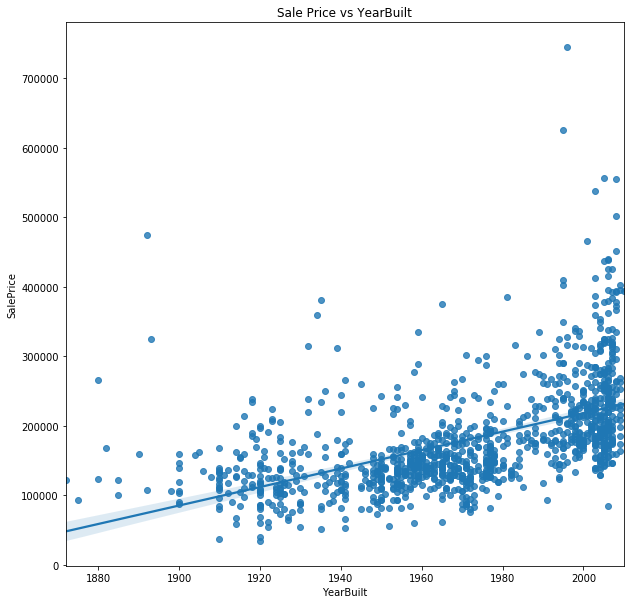

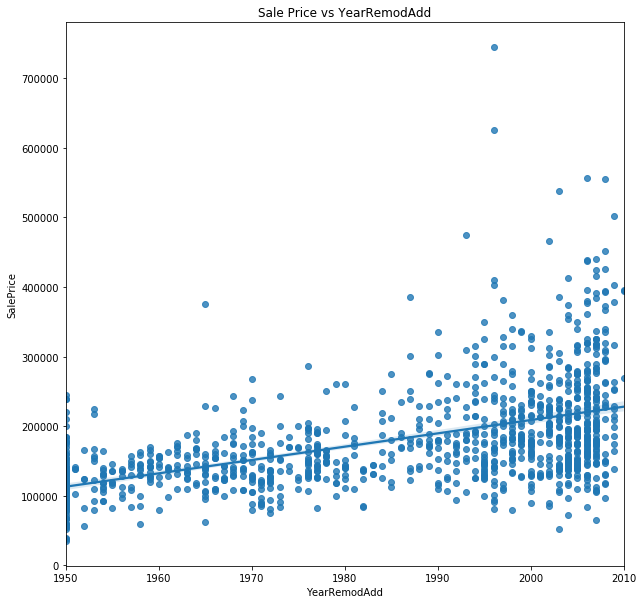

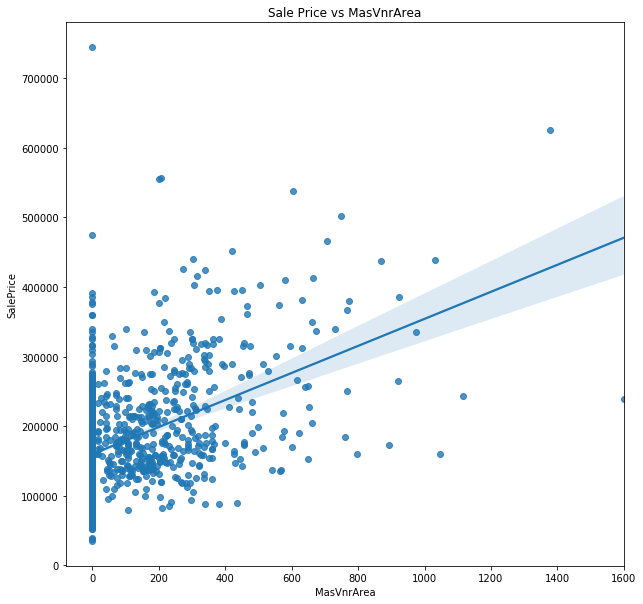

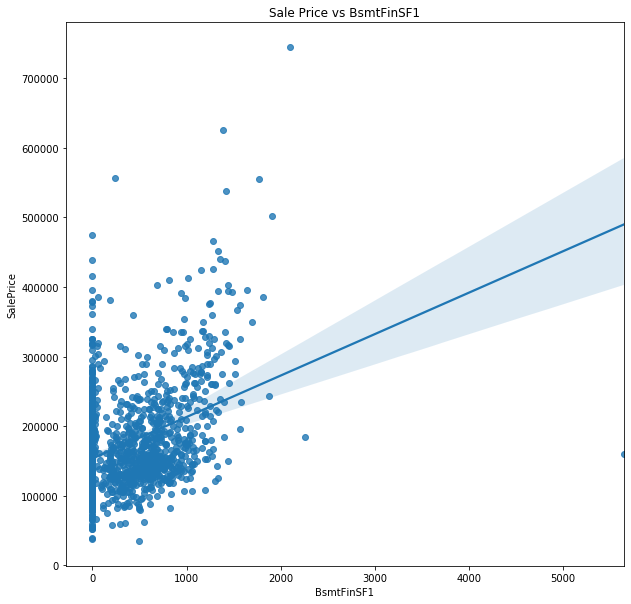

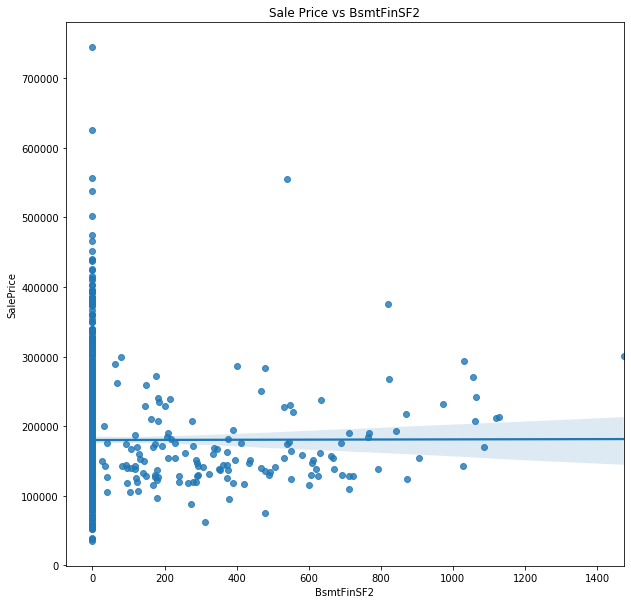

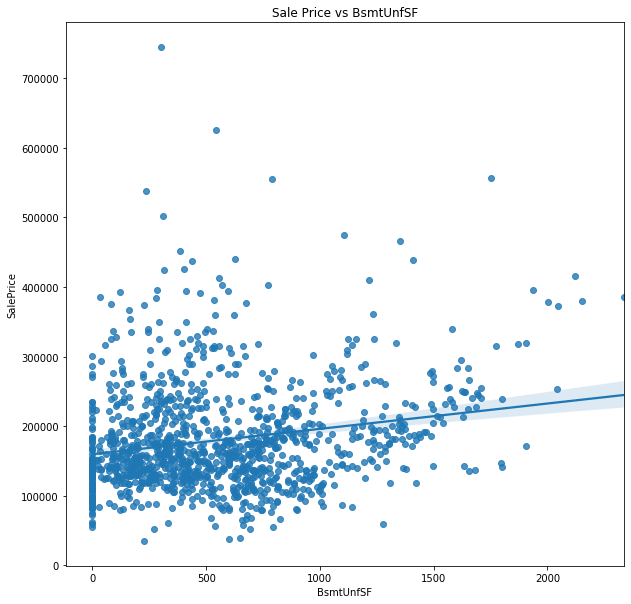

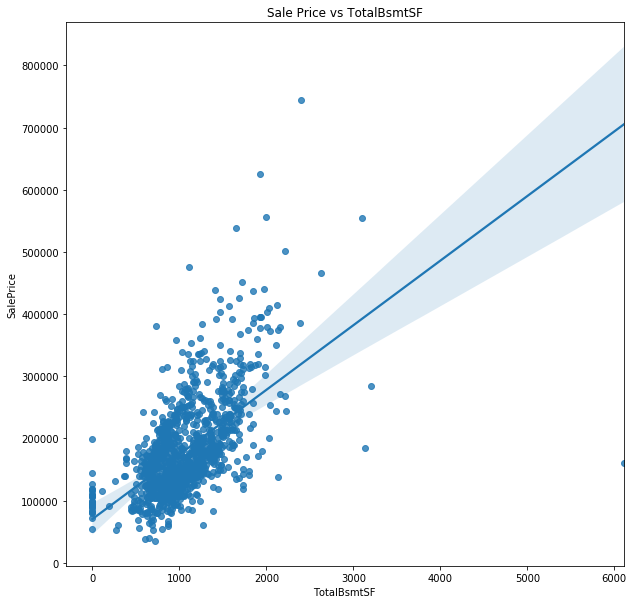

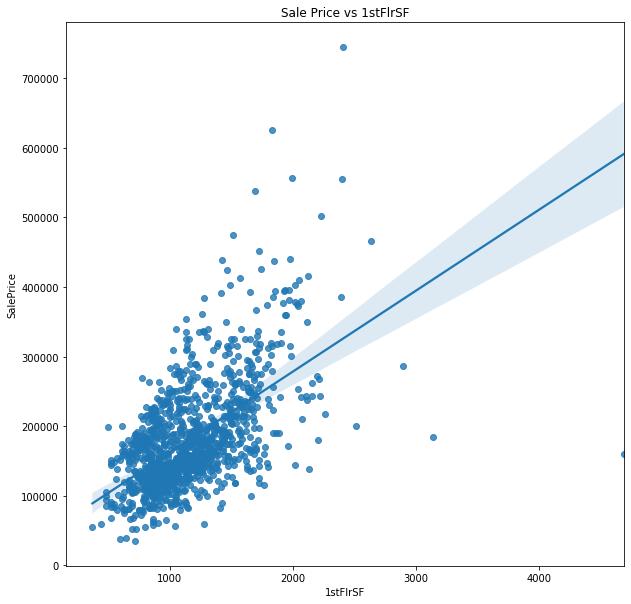

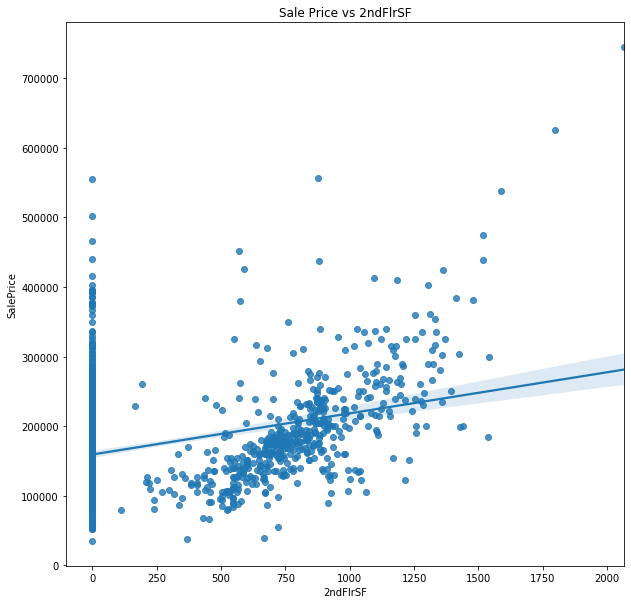

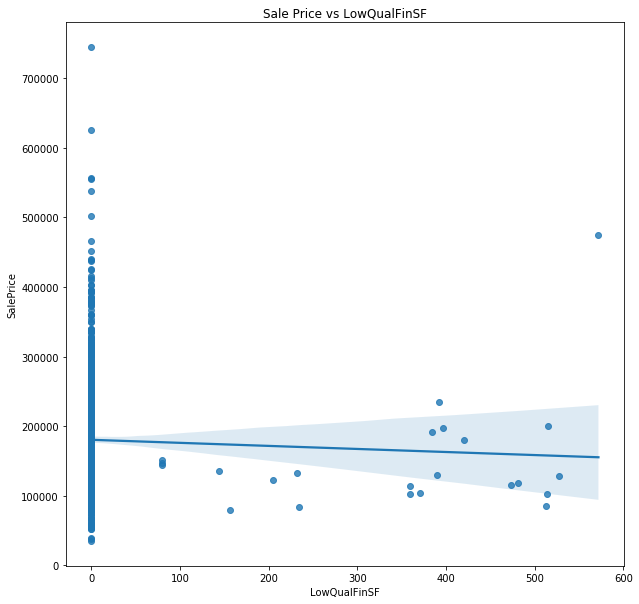

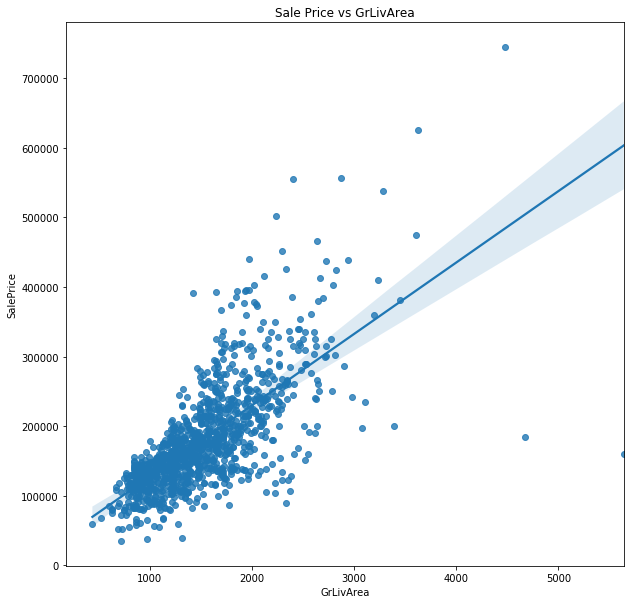

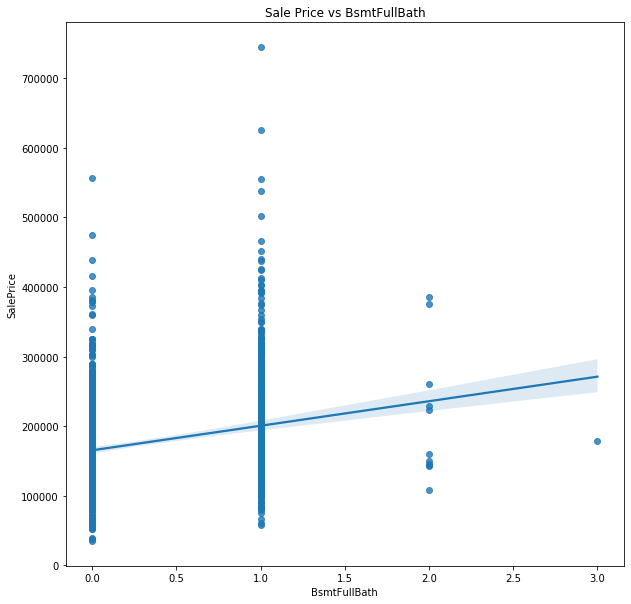

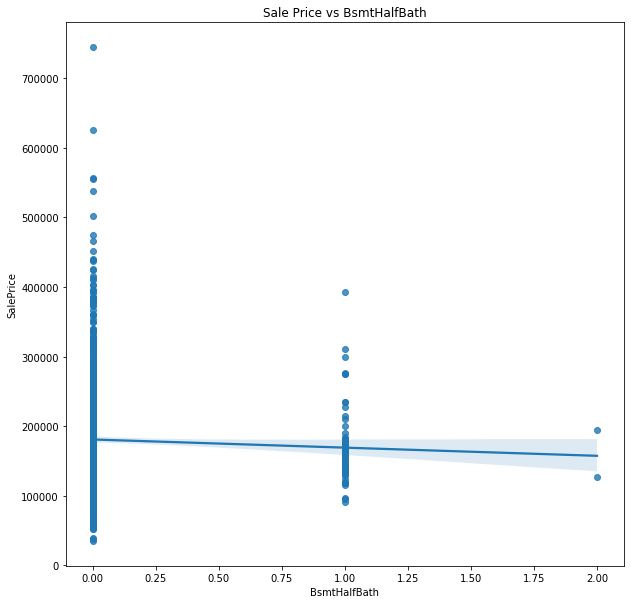

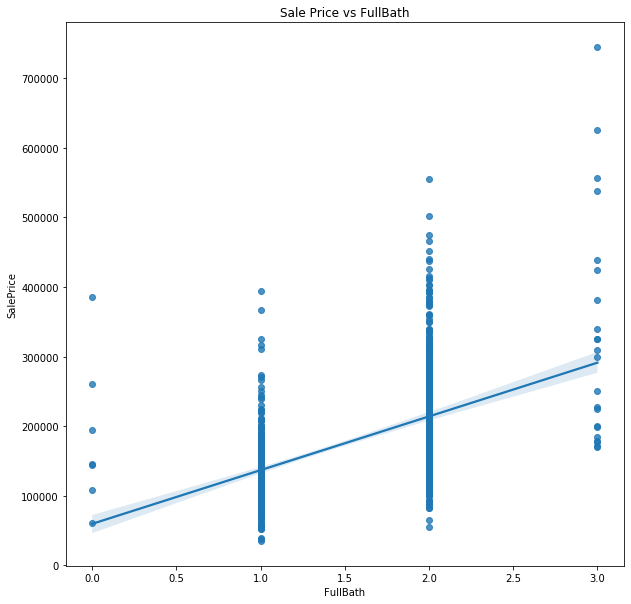

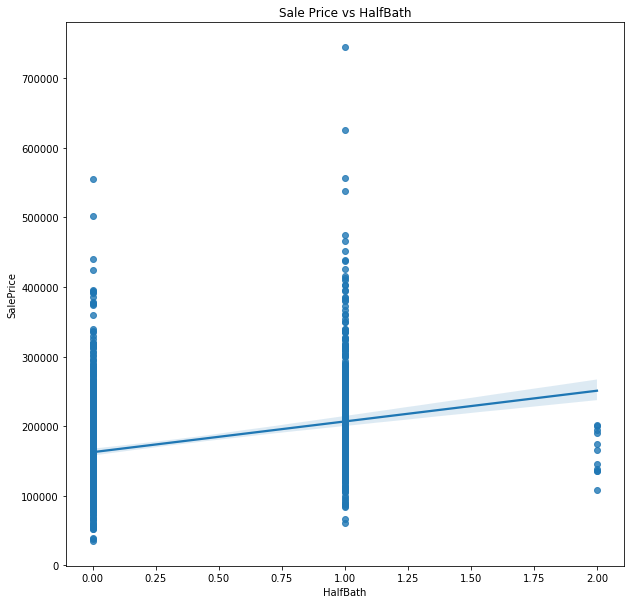

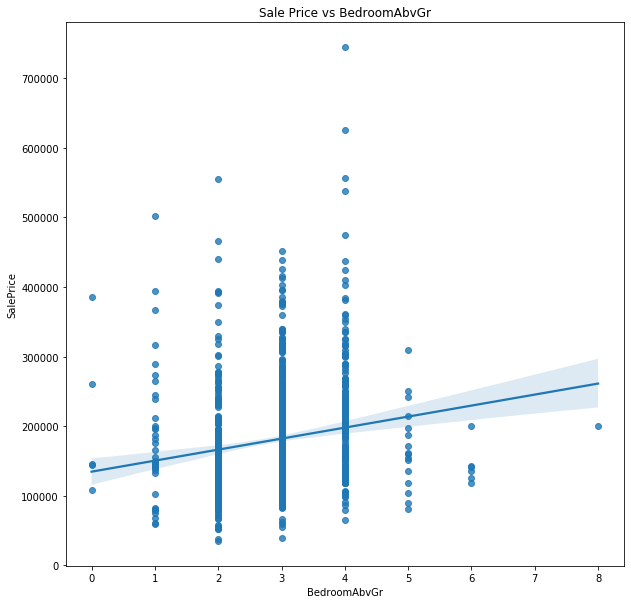

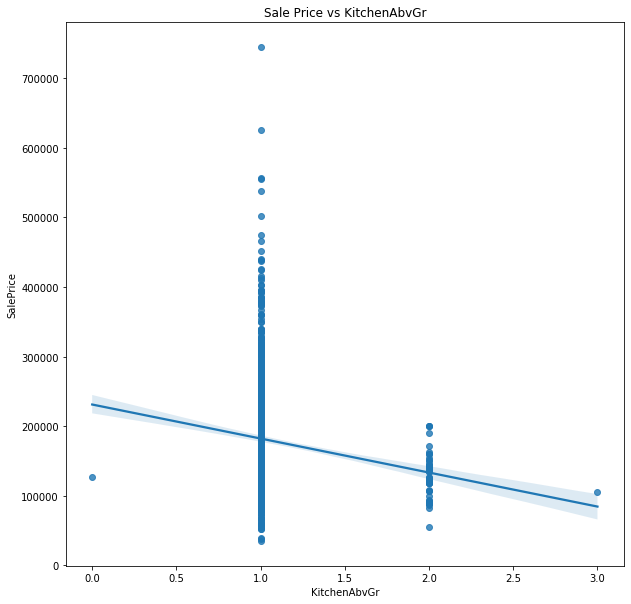

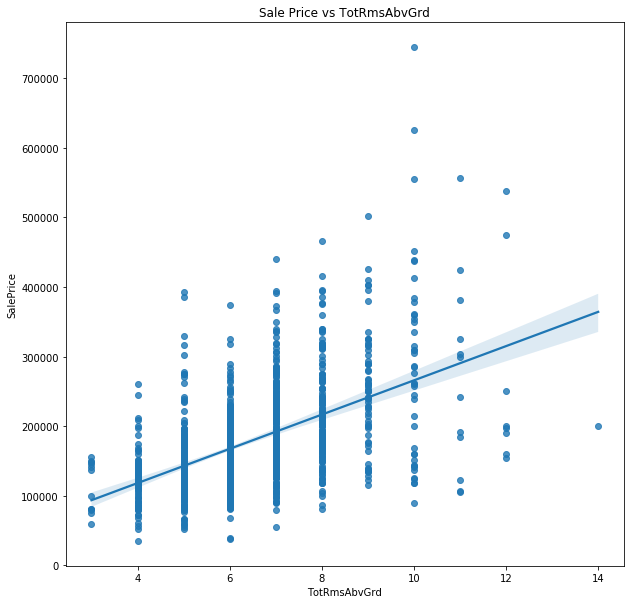

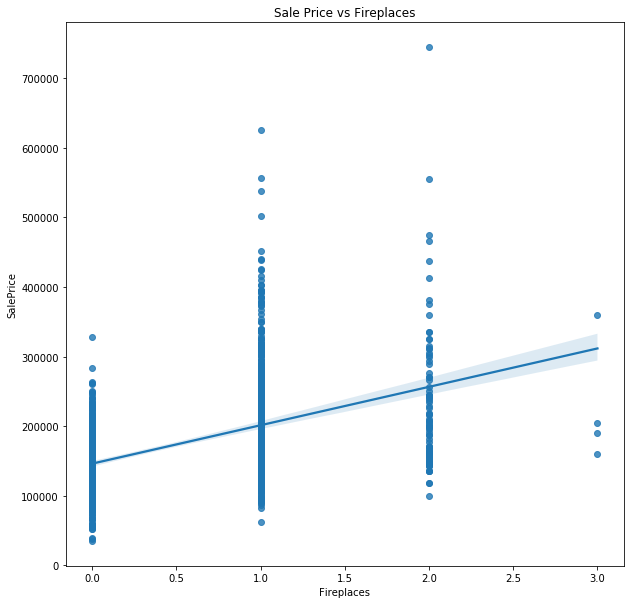

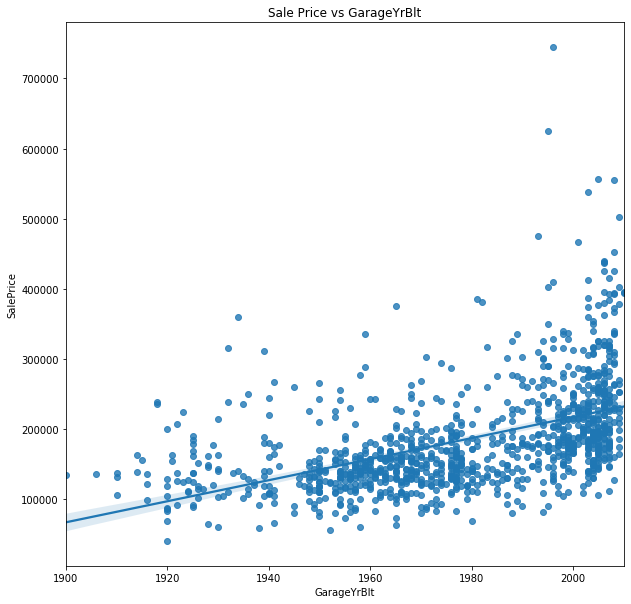

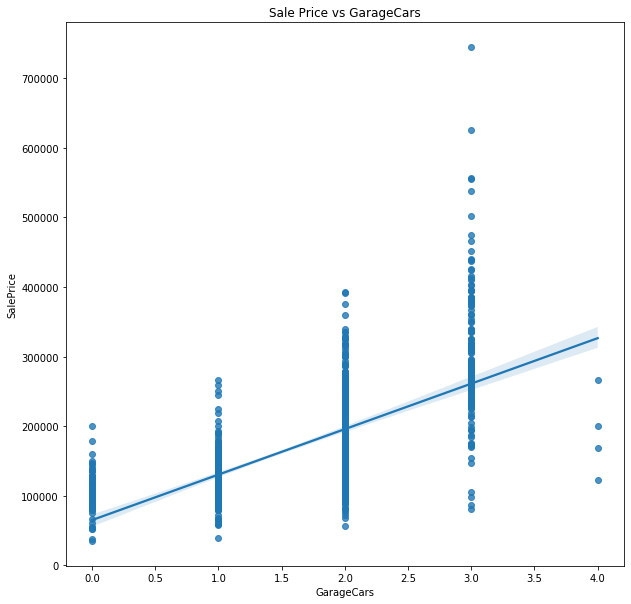

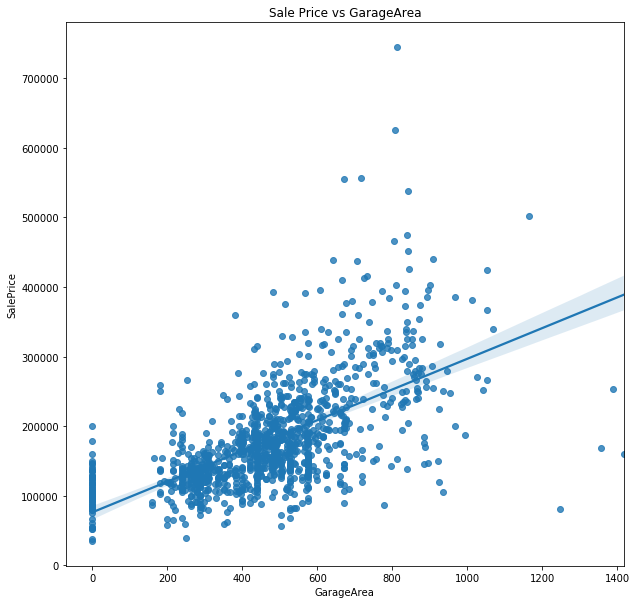

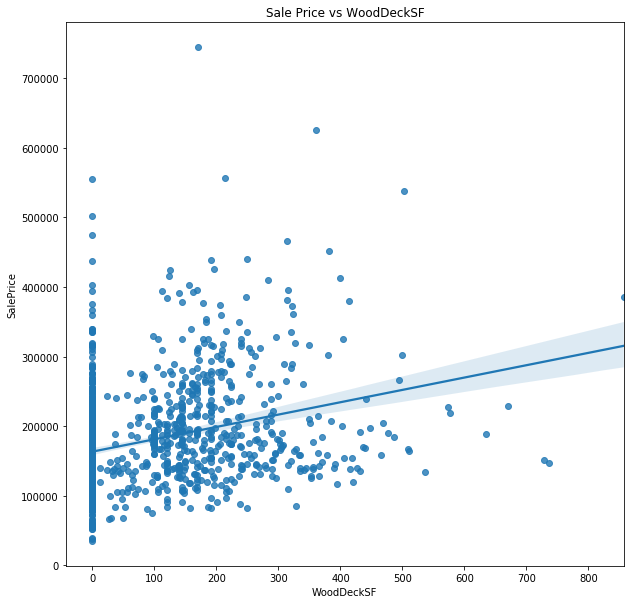

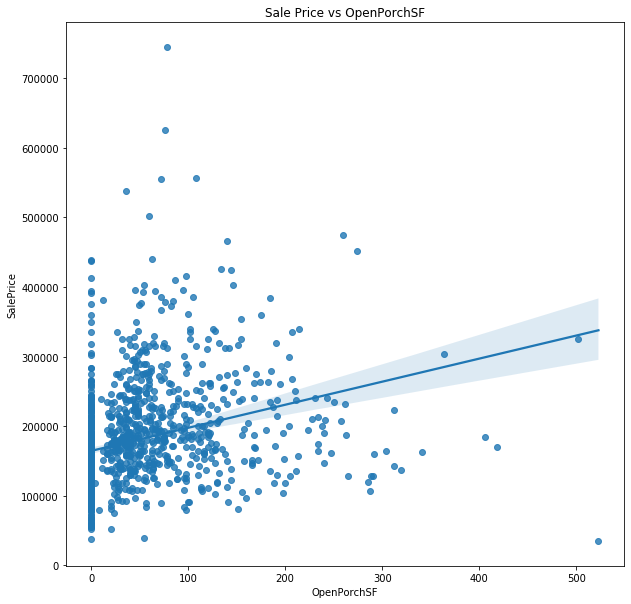

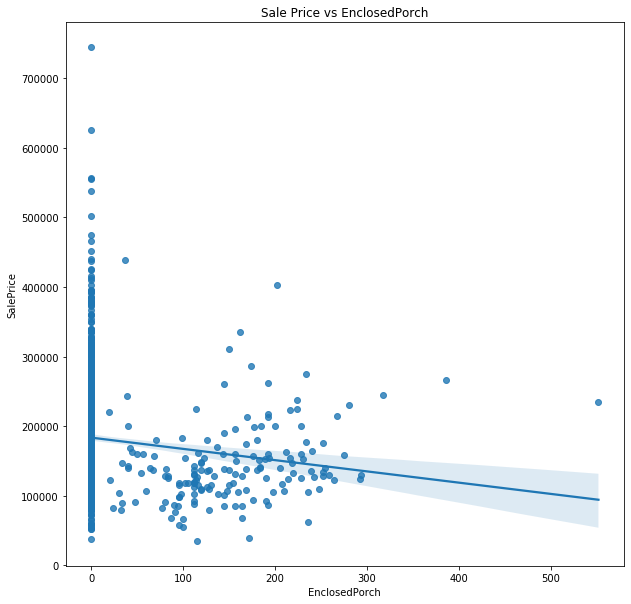

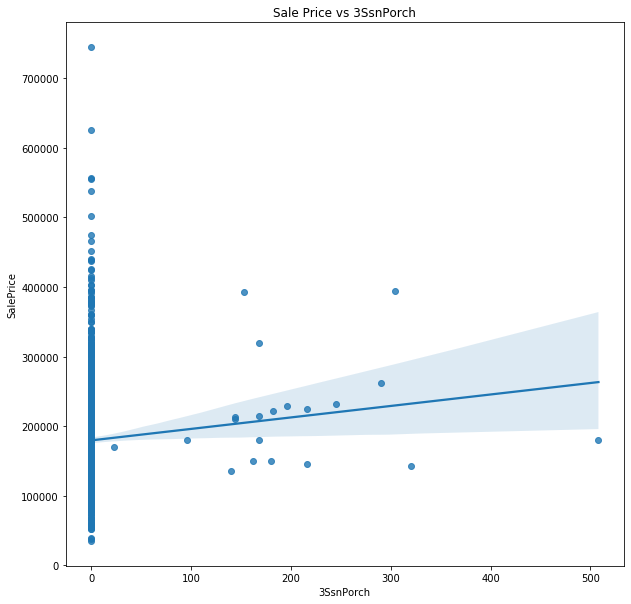

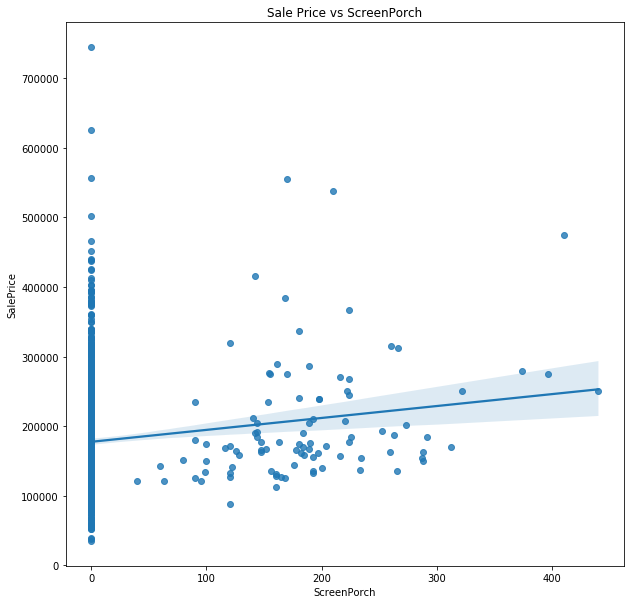

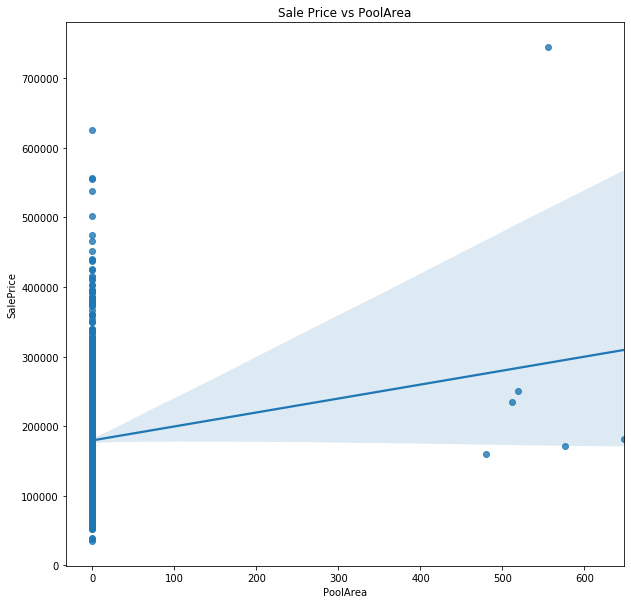

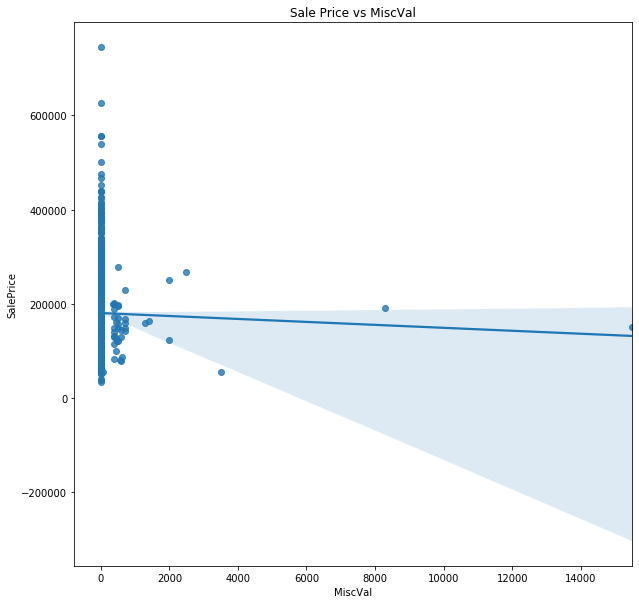

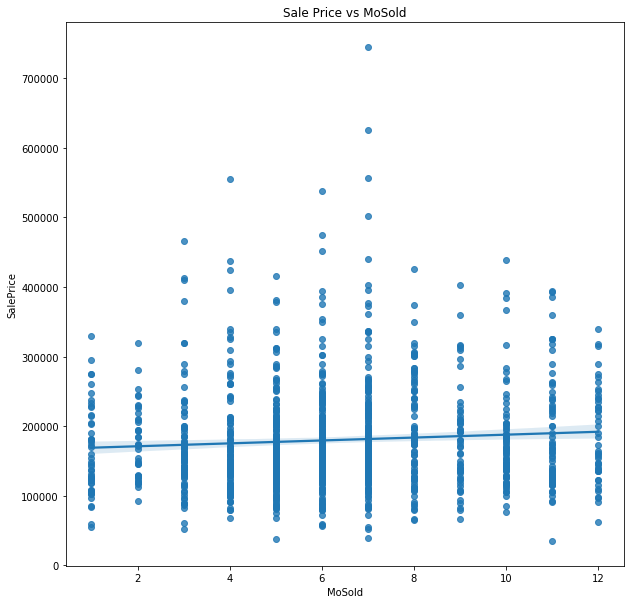

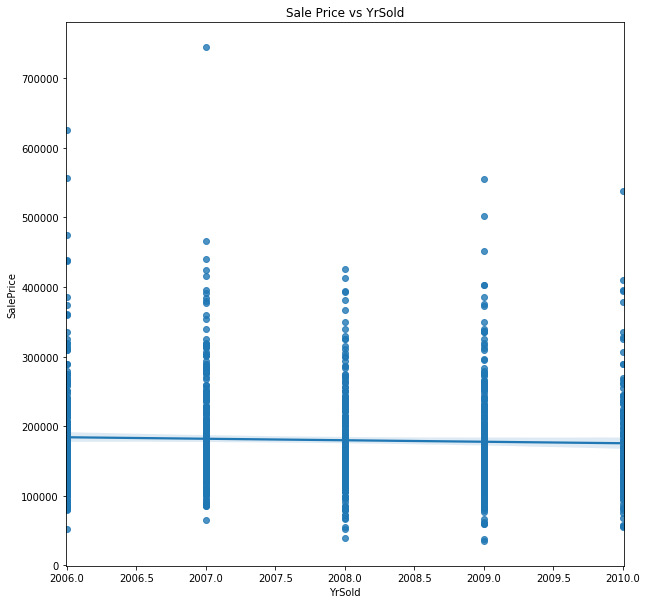

In [4]:
# Let's try to do regression only for numerical features vs target

count = 0

for feature in train.columns:
    if is_numeric_dtype(train[feature]) and feature != 'SalePrice':
        count += 1
        plt.figure(figsize = (10, 10))
        plt.title(f'Sale Price vs {feature}')
        sns.regplot(x = feature, y = 'SalePrice', data = train)
        plt.show()

Some initial thoughts based on these graphs:
1. Many of these features do not seem correlated with our target. However, we must not forget that there may be interactions between these seemingly irrelevant features which ARE correlated with our target.

# Preprocessing the Data

In [18]:
display(train)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
27      28          20       RL         98.0    11478   Pave   NaN      Reg   
911    912          20       RL          NaN     9286   Pave   NaN      IR1   
1060  1061         120       RL         41.0     4920   Pave   NaN      Reg   
281    282          20       FV         60.0     7200   Pave  Pave      Reg   
309    310          20       RL         90.0    12378   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1335  1336          20       RL         80.0     9650   Pave   NaN      Reg   
321    322          60       RL         99.0    12099   Pave   NaN      IR1   
564    565          60       RL          NaN    13346   Pave   NaN      IR1   
34      35         120       RL         60.0     7313   Pave   NaN      Reg   
346    347          20       RL          NaN    12772   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
27           Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
911          Lvl    AllPub   CulDSac       Mod      CollgCr       Norm   
1060         Lvl    AllPub    Inside       Gtl      StoneBr       Norm   
281          Lvl    AllPub    Inside       Gtl      Somerst       Norm   
309          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
...          ...       ...       ...       ...          ...        ...   
1335         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
321          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
564          Lvl    AllPub   CulDSac       Gtl      NoRidge       Norm   
34           Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
346          Lvl    AllPub   CulDSac       Gtl        NAmes       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
27         Norm     1Fam     1Story            8            5       2007   
911        Norm     1Fam     1Story            5            7       1977   
1060       Norm   TwnhsE     1Story            8            5       2001   
281        Norm     1Fam     1Story            6            5       2006   
309        Norm     1Fam     1Story            9            5       2003   
...         ...      ...        ...          ...          ...        ...   
1335       Norm     1Fam     1Story            6            5       1977   
321        Norm     1Fam     2Story            8            5       2004   
564        Norm     1Fam     2Story            7            5       1992   
34         Norm   TwnhsE     1Story            9            5       2005   
346        Norm     1Fam     1Story            6            8       1960   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
27            2008     Gable  CompShg     VinylSd     VinylSd      Stone   
911           1989     Gable  CompShg     HdBoard     Plywood       None   
1060          2001     Gable  CompShg     CemntBd     CmentBd       None   
281           2006     Gable  CompShg     VinylSd     VinylSd      Stone   
309           2004     Gable  CompShg     VinylSd     VinylSd       None   
...            ...       ...      ...         ...         ...        ...   
1335          1977     Gable  CompShg     Plywood     Plywood    BrkFace   
321           2004     Gable  CompShg     VinylSd     VinylSd    BrkFace   
564           2000     Gable  CompShg     HdBoard     HdBoard       None   
34            2005       Hip  CompShg     MetalSd     MetalSd    BrkFace   
346           1998       Hip  CompShg     MetalSd     MetalSd       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
27         200.0        Gd        TA      PConc       Ex       TA   
911          0.0        TA        TA     CBlock       Gd       Gd   
1060         0.0        Gd        TA      PConc       Gd       TA   
281         68.0        Gd        TA      PConc       Gd       TA   

In [19]:
display(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [20]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1168.000000  1168.000000   966.000000    1168.000000  1168.000000   
mean    732.187500    57.247432    69.494824   10378.026541     6.101884   
std     419.106987    42.543647    24.140596    9033.656107     1.399864   
min       2.000000    20.000000    21.000000    1477.000000     1.000000   
25%     364.750000    20.000000    58.000000    7338.000000     5.000000   
50%     737.000000    50.000000    69.000000    9327.000000     6.000000   
75%    1089.250000    70.000000    80.000000   11500.000000     7.000000   
max    1460.000000   190.000000   313.000000  164660.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1168.000000  1168.000000   1168.000000  1163.000000  1168.000000   
mean      5.558219  1970.847603   1984.515411   100.111780   449.884418   
std       1.099209    30.588583     20.729203   176.271358   464.170057   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1953.000000   1966.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1993.000000     0.000000   382.000000   
75%       6.000000  2001.000000   2004.000000   158.500000   719.250000   
max       9.000000  2010.000000   2010.000000  1378.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1168.000000  1168.000000  1168.000000  1168.000000  1168.000000   
mean     47.579623   568.991438  1066.455479  1169.987158   342.014555   
std     164.720757   443.853294   442.574764   389.856479   435.808403   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   220.500000   796.000000   893.750000     0.000000   
50%       0.000000   475.000000  1004.000000  1092.000000     0.000000   
75%       0.000000   808.000000  1314.000000  1392.000000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1168.000000  1168.000000   1168.000000   1168.000000  1168.000000   
mean       6.287671  1518.289384      0.432363      0.063356     1.568493   
std       49.689864   523.746056      0.524185      0.250640     0.555814   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1135.750000      0.000000      0.000000     1.000000   
50%        0.000000  1465.000000      0.000000      0.000000     2.000000   
75%        0.000000  1775.250000      1.000000      0.000000     2.000000   
max      528.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1168.000000   1168.000000   1168.000000   1168.000000  1168.000000   
mean      0.376712      2.861301      1.050514      6.519692     0.620719   
std       0.503838      0.829786      0.230531      1.626565     0.659112   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1099.000000  1168.000000  1168.000000  1168.000000  1168.000000   
mean   1978.480437     1.756849   470.128425    93.705479    46.166096   
std      24.807094     0.748002   211.821777   123.571358    65.439911   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   326.000000     0.000000     0.000000   
50%    1980.000000     2.000000   479.500000     0.000000    24.000000   
75%    2002.000000     2.000000   576.000000   168.000000    67.250000   
max    2

Let's see which features are missing a lot of data (15% or more), and drop those.  

We have to drop from valid, train, and test sets. ONLY USE THE INFO FROM THE TRAIN TO MAKE THE DROPS.

In [21]:
train_null = train.isnull()
train_null_sum = train_null[train_null.columns[train_null.sum() > len(train) * .15]].sum()
display(train_null_sum)
print('')
display(train.columns[train.isnull().sum() > len(train) * .15])
print('')
display(train[train.columns[train.isnull().sum() > len(train) * .15]])

LotFrontage     202
Alley          1090
FireplaceQu     554
PoolQC         1162
Fence           949
MiscFeature    1124
dtype: int64

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

LotFrontage Alley FireplaceQu PoolQC Fence MiscFeature
27           98.0   NaN          Gd    NaN   NaN         NaN
911           NaN   NaN         NaN    NaN   NaN         NaN
1060         41.0   NaN         NaN    NaN   NaN         NaN
281          60.0  Pave         NaN    NaN   NaN         NaN
309          90.0   NaN          Ex    NaN   NaN         NaN
...           ...   ...         ...    ...   ...         ...
1335         80.0   NaN          TA    NaN   NaN         NaN
321          99.0   NaN          Gd    NaN   NaN         NaN
564           NaN   NaN          TA    NaN   NaN         NaN
34           60.0   NaN          Gd    NaN   NaN         NaN
346           NaN   NaN         NaN    NaN   NaN        Gar2

[1168 rows x 6 columns]

All of these features seem peripheral, and not useful to our model, so let's just drop them.

In [22]:
columns_to_drop = train.columns[train.isnull().sum() > len(train) * .15]
display(columns_to_drop)
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)
display(train)
display(valid)
display(test)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
27      28          20       RL    11478   Pave      Reg         Lvl   
911    912          20       RL     9286   Pave      IR1         Lvl   
1060  1061         120       RL     4920   Pave      Reg         Lvl   
281    282          20       FV     7200   Pave      Reg         Lvl   
309    310          20       RL    12378   Pave      IR1         Lvl   
...    ...         ...      ...      ...    ...      ...         ...   
1335  1336          20       RL     9650   Pave      Reg         Lvl   
321    322          60       RL    12099   Pave      IR1         Lvl   
564    565          60       RL    13346   Pave      IR1         Lvl   
34      35         120       RL     7313   Pave      Reg         Lvl   
346    347          20       RL    12772   Pave      IR1         Lvl   

     Utilities LotConfig LandSlope Neighborhood Condition1 Condition2  \
27      AllPub    Inside       Gtl      NridgHt       Norm       Norm   
911     AllPub   CulDSac       Mod      CollgCr       Norm       Norm   
1060    AllPub    Inside       Gtl      StoneBr       Norm       Norm   
281     AllPub    Inside       Gtl      Somerst       Norm       Norm   
309     AllPub    Inside       Gtl      NridgHt       Norm       Norm   
...        ...       ...       ...          ...        ...        ...   
1335    AllPub    Inside       Gtl       NWAmes       Norm       Norm   
321     AllPub    Inside       Gtl      NridgHt       Norm       Norm   
564     AllPub   CulDSac       Gtl      NoRidge       Norm       Norm   
34      AllPub    Inside       Gtl      NridgHt       Norm       Norm   
346     AllPub   CulDSac       Gtl        NAmes       Norm       Norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
27       1Fam     1Story            8            5       2007          2008   
911      1Fam     1Story            5            7       1977          1989   
1060   TwnhsE     1Story            8            5       2001          2001   
281      1Fam     1Story            6            5       2006          2006   
309      1Fam     1Story            9            5       2003          2004   
...       ...        ...          ...          ...        ...           ...   
1335     1Fam     1Story            6            5       1977          1977   
321      1Fam     2Story            8            5       2004          2004   
564      1Fam     2Story            7            5       1992          2000   
34     TwnhsE     1Story            9            5       2005          2005   
346      1Fam     1Story            6            8       1960          1998   

     RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea  \
27       Gable  CompShg     VinylSd     VinylSd      Stone       200.0   
911      Gable  CompShg     HdBoard     Plywood       None         0.0   
1060     Gable  CompShg     CemntBd     CmentBd       None         0.0   
281      Gable  CompShg     VinylSd     VinylSd      Stone        68.0   
309      Gable  CompShg     VinylSd     VinylSd       None         0.0   
...        ...      ...         ...         ...        ...         ...   
1335     Gable  CompShg     Plywood     Plywood    BrkFace       360.0   
321      Gable  CompShg     VinylSd     VinylSd    BrkFace       388.0   
564      Gable  CompShg     HdBoard     HdBoard       None         0.0   
34         Hip  CompShg     MetalSd     MetalSd    BrkFace       246.0   
346        Hip  CompShg     MetalSd     MetalSd       None         0.0   

     ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
27          Gd        TA      PConc       Ex       TA           No   
911         TA        TA     CBlock       Gd       Gd           Av   
1060        Gd        TA      PConc       Gd       TA           Mn   
281         Gd        TA      PConc       Gd       TA           No   
309         Gd        TA      PConc       Ex       TA           Gd   
...     

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
135    136          20       RL    10400   Pave      Reg         Lvl   
86      87          60       RL    11911   Pave      IR2         Lvl   
473    474          20       RL    14977   Pave      IR1         Lvl   
1080  1081          20       RL    11040   Pave      Reg         Lvl   
856    857          80       RL    10970   Pave      IR1         Low   
...    ...         ...      ...      ...    ...      ...         ...   
884    885          20       RL     7150   Pave      Reg         Lvl   
408    409          60       RL    14154   Pave      Reg         Lvl   
65      66          60       RL     9591   Pave      Reg         Lvl   
526    527          20       RL    13300   Pave      Reg         Lvl   
45      46         120       RL     7658   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope Neighborhood Condition1 Condition2  \
135     AllPub    Inside       Gtl       NWAmes       Norm       Norm   
86      AllPub    Inside       Gtl      Gilbert       Norm       Norm   
473     AllPub    Inside       Gtl      NridgHt       Norm       Norm   
1080    AllPub    Inside       Gtl       NWAmes       Norm       Norm   
856     AllPub    Inside       Mod      CollgCr       Norm       Norm   
...        ...       ...       ...          ...        ...        ...   
884     AllPub    Inside       Gtl        NAmes       Norm       Norm   
408     AllPub    Corner       Gtl      NridgHt       Norm       Norm   
65      AllPub    Inside       Gtl      NridgHt       Norm       Norm   
526     AllPub    Inside       Gtl        NAmes       Norm       Norm   
45      AllPub    Inside       Gtl      NridgHt       Norm       Norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
135      1Fam     1Story            7            6       1970          1970   
86       1Fam     2Story            6            5       2005          2005   
473      1Fam     1Story            8            5       2006          2007   
1080     1Fam     1Story            6            7       1971          2004   
856      1Fam       SLvl            6            6       1978          1978   
...       ...        ...          ...          ...        ...           ...   
884      1Fam     1Story            5            5       1967          1967   
408      1Fam     2Story            7            5       2006          2006   
65       1Fam     2Story            8            5       2004          2005   
526      1Fam     1Story            5            7       1956          2000   
45     TwnhsE     1Story            9            5       2005          2005   

     RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea  \
135        Hip  CompShg     Plywood     Plywood    BrkFace       288.0   
86       Gable  CompShg     VinylSd     VinylSd       None         0.0   
473      Gable  CompShg     VinylSd     VinylSd    BrkFace       304.0   
1080     Gable  CompShg     VinylSd     VinylSd    BrkFace       144.0   
856      Gable  CompShg     Plywood     HdBoard       None         0.0   
...        ...      ...         ...         ...        ...         ...   
884      Gable  CompShg     HdBoard     HdBoard    BrkFace        60.0   
408      Gable  CompShg     VinylSd     VinylSd    BrkFace       350.0   
65       Gable  CompShg     VinylSd     VinylSd    BrkFace       344.0   
526        Hip  CompShg     Wd Sdng     Wd Sdng       None         0.0   
45         Hip  CompShg     MetalSd     MetalSd    BrkFace       412.0   

     ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
135         TA        TA      PConc       TA       TA           No   
86          Gd        TA      PConc       Gd       TA           Av   
473         Gd        TA      PConc       Ex       TA           Gd   
1080        Gd        Gd     CBlock       TA       TA           No   
856         TA        TA     CBlock       Gd       Gd           Gd   
...     

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
0     1461          20       RH    11622   Pave      Reg         Lvl   
1     1462          20       RL    14267   Pave      IR1         Lvl   
2     1463          60       RL    13830   Pave      IR1         Lvl   
3     1464          60       RL     9978   Pave      IR1         Lvl   
4     1465         120       RL     5005   Pave      IR1         HLS   
...    ...         ...      ...      ...    ...      ...         ...   
1454  2915         160       RM     1936   Pave      Reg         Lvl   
1455  2916         160       RM     1894   Pave      Reg         Lvl   
1456  2917          20       RL    20000   Pave      Reg         Lvl   
1457  2918          85       RL    10441   Pave      Reg         Lvl   
1458  2919          60       RL     9627   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope Neighborhood Condition1 Condition2  \
0       AllPub    Inside       Gtl        NAmes      Feedr       Norm   
1       AllPub    Corner       Gtl        NAmes       Norm       Norm   
2       AllPub    Inside       Gtl      Gilbert       Norm       Norm   
3       AllPub    Inside       Gtl      Gilbert       Norm       Norm   
4       AllPub    Inside       Gtl      StoneBr       Norm       Norm   
...        ...       ...       ...          ...        ...        ...   
1454    AllPub    Inside       Gtl      MeadowV       Norm       Norm   
1455    AllPub    Inside       Gtl      MeadowV       Norm       Norm   
1456    AllPub    Inside       Gtl      Mitchel       Norm       Norm   
1457    AllPub    Inside       Gtl      Mitchel       Norm       Norm   
1458    AllPub    Inside       Mod      Mitchel       Norm       Norm   

     BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0        1Fam     1Story            5            6       1961          1961   
1        1Fam     1Story            6            6       1958          1958   
2        1Fam     2Story            5            5       1997          1998   
3        1Fam     2Story            6            6       1998          1998   
4      TwnhsE     1Story            8            5       1992          1992   
...       ...        ...          ...          ...        ...           ...   
1454    Twnhs     2Story            4            7       1970          1970   
1455   TwnhsE     2Story            4            5       1970          1970   
1456     1Fam     1Story            5            7       1960          1996   
1457     1Fam     SFoyer            5            5       1992          1992   
1458     1Fam     2Story            7            5       1993          1994   

     RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea  \
0        Gable  CompShg     VinylSd     VinylSd       None         0.0   
1          Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace       108.0   
2        Gable  CompShg     VinylSd     VinylSd       None         0.0   
3        Gable  CompShg     VinylSd     VinylSd    BrkFace        20.0   
4        Gable  CompShg     HdBoard     HdBoard       None         0.0   
...        ...      ...         ...         ...        ...         ...   
1454     Gable  CompShg     CemntBd     CmentBd       None         0.0   
1455     Gable  CompShg     CemntBd     CmentBd       None         0.0   
1456     Gable  CompShg     VinylSd     VinylSd       None         0.0   
1457     Gable  CompShg     HdBoard     Wd Shng       None         0.0   
1458     Gable  CompShg     HdBoard     HdBoard    BrkFace        94.0   

     ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0           TA        TA     CBlock       TA       TA           No   
1           TA        TA     CBlock       TA       TA           No   
2           TA        TA      PConc       Gd       TA           No   
3           TA        TA      PConc       TA       TA           No   
4           Gd        TA      PConc       Gd       TA           No   
...     

## Numerical Features

Let's consider the correlation coefiicients for each pair of Numerical Features

Id  MSSubClass   LotArea  OverallQual  OverallCond  \
Id             1.000000    0.010750 -0.038505    -0.033811     0.010198   
MSSubClass     0.010750    1.000000 -0.138569     0.044784    -0.055893   
LotArea       -0.038505   -0.138569  1.000000     0.104220    -0.005306   
OverallQual   -0.033811    0.044784  0.104220     1.000000    -0.094908   
OverallCond    0.010198   -0.055893 -0.005306    -0.094908     1.000000   
YearBuilt     -0.030084    0.028772  0.021766     0.581322    -0.363717   
YearRemodAdd  -0.037842    0.064170  0.023445     0.555653     0.066186   
MasVnrArea    -0.043809   -0.001678  0.143812     0.423786    -0.132133   
BsmtFinSF1    -0.002236   -0.078795  0.232252     0.240885    -0.068809   
BsmtFinSF2     0.003759   -0.063715  0.053770    -0.054267     0.026919   
BsmtUnfSF     -0.020889   -0.118633  0.003564     0.300138    -0.133223   
TotalBsmtSF   -0.021895   -0.225329  0.267171     0.533446    -0.195755   
1stFlrSF      -0.001994   -0.229992  0.302851     0.481175    -0.155384   
2ndFlrSF       0.005647    0.295923  0.061497     0.278254     0.030362   
LowQualFinSF  -0.032617    0.053015 -0.005108    -0.061967     0.003866   
GrLivArea      0.000120    0.080070  0.276118     0.583824    -0.090032   
BsmtFullBath   0.010891    0.000962  0.154159     0.105740    -0.084622   
BsmtHalfBath  -0.026462   -0.007740  0.069886    -0.042836     0.089239   
FullBath       0.004096    0.139977  0.122997     0.547741    -0.183254   
HalfBath       0.007173    0.149357  0.029900     0.265063    -0.059749   
BedroomAbvGr   0.021041   -0.021747  0.116495     0.082995    -0.000534   
KitchenAbvGr  -0.001624    0.289406 -0.012072    -0.180590    -0.080938   
TotRmsAbvGrd   0.015772    0.045889  0.186292     0.412896    -0.062707   
Fireplaces    -0.023073   -0.041847  0.289704     0.393901    -0.024493   
GarageYrBlt    0.000173    0.099574 -0.024311     0.548664    -0.319286   
GarageCars     0.004762   -0.037071  0.163674     0.613711    -0.192248   
GarageArea     0.005652   -0.095528  0.200850     0.572094    -0.159133   
WoodDeckSF    -0.039366   -0.025777  0.216430     0.266140    -0.018169   
OpenPorchSF    0.010610    0.005688  0.097774     0.306357    -0.031762   
EnclosedPorch  0.013562    0.003832 -0.018520    -0.116704     0.054933   
3SsnPorch     -0.048552   -0.040117  0.025358     0.052703     0.011680   
ScreenPorch    0.003483   -0.030217  0.049628     0.057341     0.032635   
PoolArea       0.046302    0.001194  0.094192     0.083068    -0.022245   
MiscVal       -0.004737   -0.006216  0.048182    -0.031676     0.079318   
MoSold         0.021087   -0.023560 -0.004227     0.066294     0.016119   
YrSold         0.024953   -0.019227 -0.027040    -0.012691     0.031139   
SalePrice     -0.032410   -0.079748  0.263656     0.793399    -0.090758   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
Id             -0.030084     -0.037842   -0.043809   -0.002236    0.003759   
MSSubClass      0.028772      0.064170   -0.001678   -0.078795   -0.063715   
LotArea         0.021766      0.023445    0.143812    0.232252    0.053770   
OverallQual     0.581322      0.555653    0.423786    0.240885   -0.054267   
OverallCond    -0.363717      0.066186   -0.132133   -0.068809    0.026919   
YearBuilt       1.000000      0.592325    0.321129    0.258023   -0.035866   
YearRemodAdd    0.592325      1.000000    0.191853    0.135628   -0.080906   
MasVnrArea      0.321129      0.191853    1.000000    0.275973   -0.075162   
BsmtFinSF1      0.258023      0.135628    0.275973    1.000000   -0.061208   
BsmtFinSF2     -0.035866     -0.080906   -0.075162   -0.061208    1.000000   
BsmtUnfSF       0.134372      0.178625    0.108634   -0.495997   -0.205071   
TotalBsmtSF     0.392024      0.291275    0.370389    0.528584    0.102329   
1stFlrSF        0.297067      0.247573    0.360315    0.455979    0.103196   
2ndFlrSF       -0.010611      0.136232    0.159589   -0.149105   -0.090963   


Id              1.000000
PoolArea        0.046302
YrSold          0.024953
MoSold          0.021087
BedroomAbvGr    0.021041
Name: Id, dtype: float64

MSSubClass      1.000000
2ndFlrSF        0.295923
KitchenAbvGr    0.289406
HalfBath        0.149357
FullBath        0.139977
Name: MSSubClass, dtype: float64

LotArea        1.000000
1stFlrSF       0.302851
Fireplaces     0.289704
GrLivArea      0.276118
TotalBsmtSF    0.267171
Name: LotArea, dtype: float64

OverallQual    1.000000
SalePrice      0.793399
GarageCars     0.613711
GrLivArea      0.583824
YearBuilt      0.581322
Name: OverallQual, dtype: float64

OverallCond      1.000000
BsmtHalfBath     0.089239
MiscVal          0.079318
YearRemodAdd     0.066186
EnclosedPorch    0.054933
Name: OverallCond, dtype: float64

YearBuilt       1.000000
GarageYrBlt     0.817498
YearRemodAdd    0.592325
OverallQual     0.581322
GarageCars      0.552059
Name: YearBuilt, dtype: float64

YearRemodAdd    1.000000
GarageYrBlt     0.654194
YearBuilt       0.592325
OverallQual     0.555653
SalePrice       0.516005
Name: YearRemodAdd, dtype: float64

MasVnrArea     1.000000
SalePrice      0.506257
OverallQual    0.423786
GrLivArea      0.393222
GarageArea     0.388105
Name: MasVnrArea, dtype: float64

BsmtFinSF1      1.000000
BsmtFullBath    0.653257
TotalBsmtSF     0.528584
1stFlrSF        0.455979
SalePrice       0.401960
Name: BsmtFinSF1, dtype: float64

BsmtFinSF2      1.000000
BsmtFullBath    0.129484
1stFlrSF        0.103196
TotalBsmtSF     0.102329
ScreenPorch     0.100110
Name: BsmtFinSF2, dtype: float64

BsmtUnfSF      1.000000
TotalBsmtSF    0.406365
1stFlrSF       0.312917
OverallQual    0.300138
FullBath       0.283765
Name: BsmtUnfSF, dtype: float64

TotalBsmtSF    1.000000
1stFlrSF       0.830457
SalePrice      0.618372
OverallQual    0.533446
BsmtFinSF1     0.528584
Name: TotalBsmtSF, dtype: float64

1stFlrSF       1.000000
TotalBsmtSF    0.830457
SalePrice      0.612149
GrLivArea      0.566714
GarageArea     0.488811
Name: 1stFlrSF, dtype: float64

2ndFlrSF        1.000000
GrLivArea       0.680840
TotRmsAbvGrd    0.606560
HalfBath        0.584826
BedroomAbvGr    0.499805
Name: 2ndFlrSF, dtype: float64

LowQualFinSF     1.000000
TotRmsAbvGrd     0.127314
GrLivArea        0.122629
BedroomAbvGr     0.112612
EnclosedPorch    0.079791
Name: LowQualFinSF, dtype: float64

GrLivArea       1.000000
TotRmsAbvGrd    0.820122
SalePrice       0.708142
2ndFlrSF        0.680840
FullBath        0.621034
Name: GrLivArea, dtype: float64

BsmtFullBath    1.000000
BsmtFinSF1      0.653257
TotalBsmtSF     0.308284
1stFlrSF        0.252983
SalePrice       0.233718
Name: BsmtFullBath, dtype: float64

BsmtHalfBath    1.000000
BsmtFinSF2      0.089499
OverallCond     0.089239
LotArea         0.069886
BsmtFinSF1      0.066205
Name: BsmtHalfBath, dtype: float64

FullBath        1.000000
GrLivArea       0.621034
SalePrice       0.557546
OverallQual     0.547741
TotRmsAbvGrd    0.544928
Name: FullBath, dtype: float64

HalfBath        1.000000
2ndFlrSF        0.584826
GrLivArea       0.398285
TotRmsAbvGrd    0.329716
SalePrice       0.283722
Name: HalfBath, dtype: float64

BedroomAbvGr    1.000000
TotRmsAbvGrd    0.665475
GrLivArea       0.508231
2ndFlrSF        0.499805
FullBath        0.349473
Name: BedroomAbvGr, dtype: float64

KitchenAbvGr    1.000000
TotRmsAbvGrd    0.290996
MSSubClass      0.289406
BedroomAbvGr    0.220318
FullBath        0.130133
Name: KitchenAbvGr, dtype: float64

TotRmsAbvGrd    1.000000
GrLivArea       0.820122
BedroomAbvGr    0.665475
2ndFlrSF        0.606560
FullBath        0.544928
Name: TotRmsAbvGrd, dtype: float64

Fireplaces     1.000000
SalePrice      0.457121
GrLivArea      0.450237
1stFlrSF       0.405552
OverallQual    0.393901
Name: Fireplaces, dtype: float64

GarageYrBlt     1.000000
YearBuilt       0.817498
YearRemodAdd    0.654194
GarageCars      0.601960
GarageArea      0.573563
Name: GarageYrBlt, dtype: float64

GarageCars     1.000000
GarageArea     0.887186
SalePrice      0.640228
OverallQual    0.613711
GarageYrBlt    0.601960
Name: GarageCars, dtype: float64

GarageArea     1.000000
GarageCars     0.887186
SalePrice      0.617871
GarageYrBlt    0.573563
OverallQual    0.572094
Name: GarageArea, dtype: float64

WoodDeckSF     1.000000
SalePrice      0.347264
OverallQual    0.266140
GrLivArea      0.256482
GarageCars     0.249253
Name: WoodDeckSF, dtype: float64

OpenPorchSF    1.000000
SalePrice      0.312862
GrLivArea      0.307354
OverallQual    0.306357
FullBath       0.256433
Name: OpenPorchSF, dtype: float64

EnclosedPorch    1.000000
LowQualFinSF     0.079791
2ndFlrSF         0.074942
PoolArea         0.072994
OverallCond      0.054933
Name: EnclosedPorch, dtype: float64

3SsnPorch      1.000000
1stFlrSF       0.070438
SalePrice      0.063575
TotalBsmtSF    0.060229
OverallQual    0.052703
Name: 3SsnPorch, dtype: float64

ScreenPorch    1.000000
Fireplaces     0.196898
BsmtFinSF2     0.100110
SalePrice      0.095033
TotalBsmtSF    0.092951
Name: ScreenPorch, dtype: float64

PoolArea       1.000000
GrLivArea      0.196275
BsmtFinSF1     0.190334
TotalBsmtSF    0.170875
1stFlrSF       0.147914
Name: PoolArea, dtype: float64

MiscVal         1.000000
OverallCond     0.079318
KitchenAbvGr    0.066672
LotArea         0.048182
ScreenPorch     0.037953
Name: MiscVal, dtype: float64

MoSold          1.000000
OverallQual     0.066294
BedroomAbvGr    0.060094
GrLivArea       0.056830
FullBath        0.055034
Name: MoSold, dtype: float64

YrSold          1.000000
BsmtFullBath    0.054421
KitchenAbvGr    0.040744
YearRemodAdd    0.033907
OverallCond     0.031139
Name: YrSold, dtype: float64

SalePrice      1.000000
OverallQual    0.793399
GrLivArea      0.708142
GarageCars     0.640228
TotalBsmtSF    0.618372
Name: SalePrice, dtype: float64

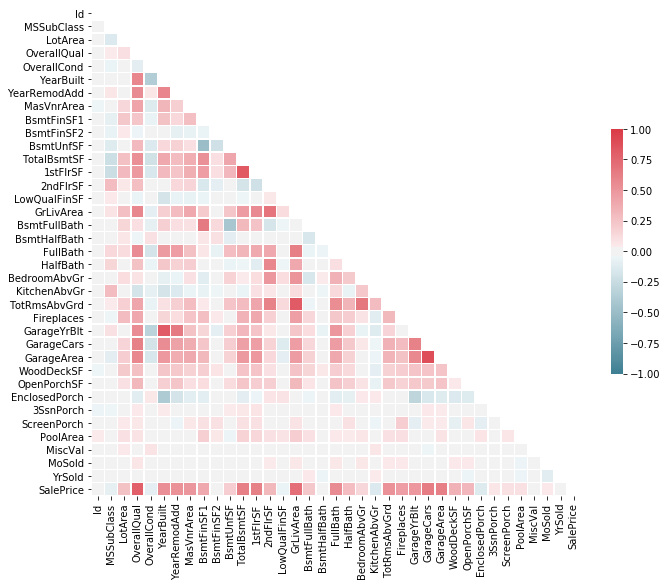

In [23]:
corr = train.corr()
display(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Interesting. There's a lot more to consider here, but for now let's just focus on numerical features that are highly correlated with our target value.  

Yes, this is a gross simplification. But we'll do multivariate analysis later. I promise!!

In [24]:
display(corr['SalePrice'].sort_values())

KitchenAbvGr    -0.134406
EnclosedPorch   -0.126443
OverallCond     -0.090758
MSSubClass      -0.079748
LowQualFinSF    -0.059639
Id              -0.032410
MiscVal         -0.021516
BsmtHalfBath    -0.018444
YrSold          -0.010201
BsmtFinSF2      -0.005779
MoSold           0.054620
3SsnPorch        0.063575
ScreenPorch      0.095033
PoolArea         0.097201
BedroomAbvGr     0.142803
BsmtUnfSF        0.198376
BsmtFullBath     0.233718
LotArea          0.263656
HalfBath         0.283722
2ndFlrSF         0.310228
OpenPorchSF      0.312862
WoodDeckSF       0.347264
BsmtFinSF1       0.401960
Fireplaces       0.457121
GarageYrBlt      0.490263
MasVnrArea       0.506257
YearRemodAdd     0.516005
TotRmsAbvGrd     0.521656
YearBuilt        0.537708
FullBath         0.557546
1stFlrSF         0.612149
GarageArea       0.617871
TotalBsmtSF      0.618372
GarageCars       0.640228
GrLivArea        0.708142
OverallQual      0.793399
SalePrice        1.000000
Name: SalePrice, dtype: float64

Let's limit our model to just correlation coefficients .5 or above. That will bring us down to 11 numerical features.

In [25]:
corr_sp = corr['SalePrice']
display(corr_sp)

print('')
columns_to_drop2 = corr_sp.loc[corr_sp < .5].index
display(columns_to_drop)

train.drop(columns_to_drop2, inplace = True, axis = 1)
valid.drop(columns_to_drop2, inplace = True, axis = 1)
test.drop(columns_to_drop2, inplace = True, axis = 1)

display(train)
display(valid)
display(test)

Id              -0.032410
MSSubClass      -0.079748
LotArea          0.263656
OverallQual      0.793399
OverallCond     -0.090758
YearBuilt        0.537708
YearRemodAdd     0.516005
MasVnrArea       0.506257
BsmtFinSF1       0.401960
BsmtFinSF2      -0.005779
BsmtUnfSF        0.198376
TotalBsmtSF      0.618372
1stFlrSF         0.612149
2ndFlrSF         0.310228
LowQualFinSF    -0.059639
GrLivArea        0.708142
BsmtFullBath     0.233718
BsmtHalfBath    -0.018444
FullBath         0.557546
HalfBath         0.283722
BedroomAbvGr     0.142803
KitchenAbvGr    -0.134406
TotRmsAbvGrd     0.521656
Fireplaces       0.457121
GarageYrBlt      0.490263
GarageCars       0.640228
GarageArea       0.617871
WoodDeckSF       0.347264
OpenPorchSF      0.312862
EnclosedPorch   -0.126443
3SsnPorch        0.063575
ScreenPorch      0.095033
PoolArea         0.097201
MiscVal         -0.021516
MoSold           0.054620
YrSold          -0.010201
SalePrice        1.000000
Name: SalePrice, dtype: float64

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
27         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
911        RL   Pave      IR1         Lvl    AllPub   CulDSac       Mod   
1060       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
281        FV   Pave      Reg         Lvl    AllPub    Inside       Gtl   
309        RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
...       ...    ...      ...         ...       ...       ...       ...   
1335       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
321        RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
564        RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
34         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
346        RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   

     Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
27        NridgHt       Norm       Norm     1Fam     1Story            8   
911       CollgCr       Norm       Norm     1Fam     1Story            5   
1060      StoneBr       Norm       Norm   TwnhsE     1Story            8   
281       Somerst       Norm       Norm     1Fam     1Story            6   
309       NridgHt       Norm       Norm     1Fam     1Story            9   
...           ...        ...        ...      ...        ...          ...   
1335       NWAmes       Norm       Norm     1Fam     1Story            6   
321       NridgHt       Norm       Norm     1Fam     2Story            8   
564       NoRidge       Norm       Norm     1Fam     2Story            7   
34        NridgHt       Norm       Norm   TwnhsE     1Story            9   
346         NAmes       Norm       Norm     1Fam     1Story            6   

      YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
27         2007          2008     Gable  CompShg     VinylSd     VinylSd   
911        1977          1989     Gable  CompShg     HdBoard     Plywood   
1060       2001          2001     Gable  CompShg     CemntBd     CmentBd   
281        2006          2006     Gable  CompShg     VinylSd     VinylSd   
309        2003          2004     Gable  CompShg     VinylSd     VinylSd   
...         ...           ...       ...      ...         ...         ...   
1335       1977          1977     Gable  CompShg     Plywood     Plywood   
321        2004          2004     Gable  CompShg     VinylSd     VinylSd   
564        1992          2000     Gable  CompShg     HdBoard     HdBoard   
34         2005          2005       Hip  CompShg     MetalSd     MetalSd   
346        1960          1998       Hip  CompShg     MetalSd     MetalSd   

     MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
27        Stone       200.0        Gd        TA      PConc       Ex       TA   
911        None         0.0        TA        TA     CBlock       Gd       Gd   
1060       None         0.0        Gd        TA      PConc       Gd       TA   
281       Stone        68.0        Gd        TA      PConc       Gd       TA   
309        None         0.0        Gd        TA      PConc       Ex       TA   
...         ...         ...       ...       ...        ...      ...      ...   
1335    BrkFace       360.0        TA        TA     CBlock       Gd       TA   
321     BrkFace       388.0        Gd        TA      PConc       Ex       TA   
564        None         0.0        Gd        TA      PConc       Gd       TA   
34      BrkFace       246.0        Ex        TA      PConc       Ex       TA   
346        None         0.0        TA        Gd     CBlock       TA       TA   

     BsmtExposure BsmtFinType1 BsmtFinType2  TotalBsmtSF Heating HeatingQC  \
27             No          GLQ          Unf         1704    GasA        Ex   
911            Av          ALQ          Unf         1268    GasA        TA   
1060           Mn          GLQ          Unf         1338    GasA        Ex   
281  

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
135        RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
86         RL   Pave      IR2         Lvl    AllPub    Inside       Gtl   
473        RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
1080       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
856        RL   Pave      IR1         Low    AllPub    Inside       Mod   
...       ...    ...      ...         ...       ...       ...       ...   
884        RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
408        RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
65         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
526        RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
45         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   

     Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
135        NWAmes       Norm       Norm     1Fam     1Story            7   
86        Gilbert       Norm       Norm     1Fam     2Story            6   
473       NridgHt       Norm       Norm     1Fam     1Story            8   
1080       NWAmes       Norm       Norm     1Fam     1Story            6   
856       CollgCr       Norm       Norm     1Fam       SLvl            6   
...           ...        ...        ...      ...        ...          ...   
884         NAmes       Norm       Norm     1Fam     1Story            5   
408       NridgHt       Norm       Norm     1Fam     2Story            7   
65        NridgHt       Norm       Norm     1Fam     2Story            8   
526         NAmes       Norm       Norm     1Fam     1Story            5   
45        NridgHt       Norm       Norm   TwnhsE     1Story            9   

      YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
135        1970          1970       Hip  CompShg     Plywood     Plywood   
86         2005          2005     Gable  CompShg     VinylSd     VinylSd   
473        2006          2007     Gable  CompShg     VinylSd     VinylSd   
1080       1971          2004     Gable  CompShg     VinylSd     VinylSd   
856        1978          1978     Gable  CompShg     Plywood     HdBoard   
...         ...           ...       ...      ...         ...         ...   
884        1967          1967     Gable  CompShg     HdBoard     HdBoard   
408        2006          2006     Gable  CompShg     VinylSd     VinylSd   
65         2004          2005     Gable  CompShg     VinylSd     VinylSd   
526        1956          2000       Hip  CompShg     Wd Sdng     Wd Sdng   
45         2005          2005       Hip  CompShg     MetalSd     MetalSd   

     MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
135     BrkFace       288.0        TA        TA      PConc       TA       TA   
86         None         0.0        Gd        TA      PConc       Gd       TA   
473     BrkFace       304.0        Gd        TA      PConc       Ex       TA   
1080    BrkFace       144.0        Gd        Gd     CBlock       TA       TA   
856        None         0.0        TA        TA     CBlock       Gd       Gd   
...         ...         ...       ...       ...        ...      ...      ...   
884     BrkFace        60.0        TA        TA     CBlock       TA       TA   
408     BrkFace       350.0        Gd        TA      PConc       Ex       Gd   
65      BrkFace       344.0        Gd        TA      PConc       Ex       TA   
526        None         0.0        TA        TA     CBlock       Gd       TA   
45      BrkFace       412.0        Ex        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1 BsmtFinType2  TotalBsmtSF Heating HeatingQC  \
135            No          Unf          Unf         1304    GasA        Gd   
86             Av          Unf          Unf          684    GasA        Ex   
473            Gd          GLQ          Unf         1976    GasA        Ex   
1080 

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
0          RH   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1          RL   Pave      IR1         Lvl    AllPub    Corner       Gtl   
2          RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
3          RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
4          RL   Pave      IR1         HLS    AllPub    Inside       Gtl   
...       ...    ...      ...         ...       ...       ...       ...   
1454       RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1455       RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1456       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1457       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1458       RL   Pave      Reg         Lvl    AllPub    Inside       Mod   

     Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
0           NAmes      Feedr       Norm     1Fam     1Story            5   
1           NAmes       Norm       Norm     1Fam     1Story            6   
2         Gilbert       Norm       Norm     1Fam     2Story            5   
3         Gilbert       Norm       Norm     1Fam     2Story            6   
4         StoneBr       Norm       Norm   TwnhsE     1Story            8   
...           ...        ...        ...      ...        ...          ...   
1454      MeadowV       Norm       Norm    Twnhs     2Story            4   
1455      MeadowV       Norm       Norm   TwnhsE     2Story            4   
1456      Mitchel       Norm       Norm     1Fam     1Story            5   
1457      Mitchel       Norm       Norm     1Fam     SFoyer            5   
1458      Mitchel       Norm       Norm     1Fam     2Story            7   

      YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
0          1961          1961     Gable  CompShg     VinylSd     VinylSd   
1          1958          1958       Hip  CompShg     Wd Sdng     Wd Sdng   
2          1997          1998     Gable  CompShg     VinylSd     VinylSd   
3          1998          1998     Gable  CompShg     VinylSd     VinylSd   
4          1992          1992     Gable  CompShg     HdBoard     HdBoard   
...         ...           ...       ...      ...         ...         ...   
1454       1970          1970     Gable  CompShg     CemntBd     CmentBd   
1455       1970          1970     Gable  CompShg     CemntBd     CmentBd   
1456       1960          1996     Gable  CompShg     VinylSd     VinylSd   
1457       1992          1992     Gable  CompShg     HdBoard     Wd Shng   
1458       1993          1994     Gable  CompShg     HdBoard     HdBoard   

     MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          None         0.0        TA        TA     CBlock       TA       TA   
1       BrkFace       108.0        TA        TA     CBlock       TA       TA   
2          None         0.0        TA        TA      PConc       Gd       TA   
3       BrkFace        20.0        TA        TA      PConc       TA       TA   
4          None         0.0        Gd        TA      PConc       Gd       TA   
...         ...         ...       ...       ...        ...      ...      ...   
1454       None         0.0        TA        TA     CBlock       TA       TA   
1455       None         0.0        TA        TA     CBlock       TA       TA   
1456       None         0.0        TA        TA     CBlock       TA       TA   
1457       None         0.0        TA        TA      PConc       Gd       TA   
1458    BrkFace        94.0        TA        TA      PConc       Gd       TA   

     BsmtExposure BsmtFinType1 BsmtFinType2  TotalBsmtSF Heating HeatingQC  \
0              No          Rec          LwQ        882.0    GasA        TA   
1              No          ALQ          Unf       1329.0    GasA        TA   
2              No          GLQ          Unf        928.0    GasA        Gd   
3    

## Categorical Features

Let's look at the Categorical Features and decide what to do with them.

In [26]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
27         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
911        RL   Pave      IR1         Lvl    AllPub   CulDSac       Mod   
1060       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
281        FV   Pave      Reg         Lvl    AllPub    Inside       Gtl   
309        RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
...       ...    ...      ...         ...       ...       ...       ...   
1335       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
321        RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
564        RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
34         RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
346        RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   

     Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle  \
27        NridgHt       Norm       Norm     1Fam     1Story     Gable   
911       CollgCr       Norm       Norm     1Fam     1Story     Gable   
1060      StoneBr       Norm       Norm   TwnhsE     1Story     Gable   
281       Somerst       Norm       Norm     1Fam     1Story     Gable   
309       NridgHt       Norm       Norm     1Fam     1Story     Gable   
...           ...        ...        ...      ...        ...       ...   
1335       NWAmes       Norm       Norm     1Fam     1Story     Gable   
321       NridgHt       Norm       Norm     1Fam     2Story     Gable   
564       NoRidge       Norm       Norm     1Fam     2Story     Gable   
34        NridgHt       Norm       Norm   TwnhsE     1Story       Hip   
346         NAmes       Norm       Norm     1Fam     1Story       Hip   

     RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond  \
27    CompShg     VinylSd     VinylSd      Stone        Gd        TA   
911   CompShg     HdBoard     Plywood       None        TA        TA   
1060  CompShg     CemntBd     CmentBd       None        Gd        TA   
281   CompShg     VinylSd     VinylSd      Stone        Gd        TA   
309   CompShg     VinylSd     VinylSd       None        Gd        TA   
...       ...         ...         ...        ...       ...       ...   
1335  CompShg     Plywood     Plywood    BrkFace        TA        TA   
321   CompShg     VinylSd     VinylSd    BrkFace        Gd        TA   
564   CompShg     HdBoard     HdBoard       None        Gd        TA   
34    CompShg     MetalSd     MetalSd    BrkFace        Ex        TA   
346   CompShg     MetalSd     MetalSd       None        TA        Gd   

     Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  \
27        PConc       Ex       TA           No          GLQ          Unf   
911      CBlock       Gd       Gd           Av          ALQ          Unf   
1060      PConc       Gd       TA           Mn          GLQ          Unf   
281       PConc       Gd       TA           No          GLQ          Unf   
309       PConc       Ex       TA           Gd          GLQ          Unf   
...         ...      ...      ...          ...          ...          ...   
1335     CBlock       Gd       TA           No          ALQ          Unf   
321       PConc       Ex       TA           Av          GLQ          Unf   
564       PConc       Gd       TA           No          GLQ          Unf   
34        PConc       Ex       TA           No          GLQ          Unf   
346      CBlock       TA       TA           Mn          BLQ          Unf   

     Heating HeatingQC CentralAir Electrical KitchenQual Functional  \
27      GasA        Ex          Y      SBrkr          Gd        Typ   
911     GasA        TA          Y      SBrkr          Gd        Typ   
1060    GasA        Ex          Y      SBrkr          Gd        Typ   
281     GasA        Gd          Y      SBrkr          Gd        Typ   
309     GasA        Ex          Y      SBrkr          Ex        Typ   
...      ...       ... 

Many of these variable seem ripe for an ordinal encoding, where we turn each entry into a number, like 0, 1, 2, 3... Note that this is a good idea for categorical features which have some inherent order. But if the feature is not ordered in some sense, then ordinal encoding will confuse the algorithm into believing* there is some inherent order. Certianly there is room for debate on just how ordinal some of these features are.  

*No, machines can't think, I'm just anthropomorphising.

Here's a list of what seem like ordinal features to me:
1.  LotShape: How regular or irregular the property is shaped
2. Utilites: Which utilites are available, as a chain of sets, which gives order.
3. LandSlope: How sloped the property is
4. ExterQual: Evaluates the quality of the material on the exterior 
5. ExterCond: Evaluates the present condition of the material on the exterior
6. BsmtQual: Evaluates the height of the basement
7. BsmtCond: Evaluates the general condition of the basement
8. BsmtExposure: Refers to walkout or garden level walls
9. BsmtFinType1: Rating of basement finished area
10. BsmtFinType2: Rating of basement finished area (if multiple types)
11. HeatingQC: Heating quality and condition
12. CentralAir: Central air conditioning
13. KitchenQual: Kitchen quality
14. Functional: Home functionality (Assume typical unless deductions are warranted)
15. FireplaceQu: Fireplace quality
16. GarageFinish: Interior finish of the garage
17. GarageQual: Garage quality
18. GarageCond: Garage condition
19. PavedDrive: Paved driveway
20. PoolQC: Pool quality
21. Fence Quality is a weird one, as it has two types of info in one category (how much privacy, and the quality of the fences construction). I'd better leave this one alone for now.

While sklearn has a nice OrdinalEncoder built in, it can't know the real world values of these descriptions (e.g. for Garage Finish we should have Finished > Rough Finished > Unfinished > No Garage, though even here there could be debate about whether No Garage is truly lower than the other options, or just incomparable). Therefore, I will have to manually encode all of these...  

Sigh...

In [ ]:
# Here are all our maps
# I'm following the convention of giving the worst value 0, and the best the maximum

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilites_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}







# Here is a list of the maps I just made, so we can just iterate through them
ordinal_maps = []

# Here's our list of columns to map, so we can just iterate through them

ordinal = ['LotShape', 'Utilites', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']

In [27]:



train.map()
valid.
test.

display(train)
display(valid)
display(test)

Now that we've turned many of our categorical variables back into numerical ones, let's check the correlation coefficients again, but just for our updated features.

## Dealing with missing values

We have a number of choices for dealing with missing values. We've already dropped features with substantial (>20%) ammount of missig values. For now, we'll take care of the rest by simple imputting with median for numerical and most common for categorical

# Training The Model

Now that we're down to a manageable number of features, let's start training and comparing models.

# Assessing our Results

Now that we've finished training one model from beginning to end, let's test it by uploading our results to Kaggle and see how we did.

# Developing a Pipeline

We went through a lot of steps to prepare our data and train our model. Let's condense as much of that as possible into a single pipeline that we can use for future datasets.

# Developing More Pipelines

This pipeline did ok, but surely we can do better if we tweak some of our steps. Let's develop some more pipelines from beginning to end, and compare the results of each.

# Comparing Models